In [1]:
# Add this at the very start of your notebook:
from google.colab import drive
drive.mount('/content/drive')

# Verify mount worked
import os
if not os.path.exists('/content/drive/MyDrive'):
    raise Exception("❌ Google Drive not mounted! Please run: drive.mount('/content/drive')")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
DRIVE_BASE_PATH = '/content/drive/MyDrive/CIFAR100_Experiment'

def setup_drive_directories():
    """Create necessary directories in Google Drive"""
    drive_dirs = [
        DRIVE_BASE_PATH,
        f"{DRIVE_BASE_PATH}/models",
        f"{DRIVE_BASE_PATH}/results",
        f"{DRIVE_BASE_PATH}/progress",
        f"{DRIVE_BASE_PATH}/plots"
    ]

    for dir_path in drive_dirs:
        os.makedirs(dir_path, exist_ok=True)

    print(f"📁 Drive directories created at: {DRIVE_BASE_PATH}")
    return DRIVE_BASE_PATH

## 1. Model Accuracy vs Training Time

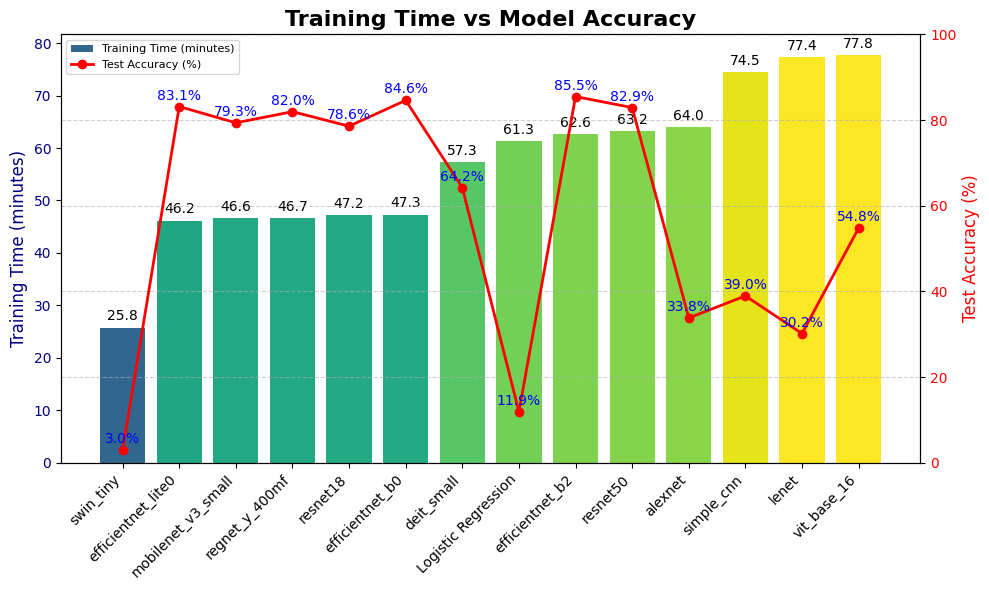

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

json_path = f"{DRIVE_BASE_PATH}/results/FINAL_experiment_results.json"

# Load JSON file
with open(json_path, "r") as f:
    data = json.load(f)

# Extract relevant data
summary_data = []
for model_id, metrics in data.items():
    summary_data.append({
        "Model": metrics["model_name"],
        "Final Test Accuracy": metrics["final_test_acc"] * 100,  # convert to %
        "Training Time (minutes)": metrics["training_time"] / 60  # convert sec to min
    })

# Create DataFrame
df = pd.DataFrame(summary_data)
df = df.sort_values(by="Training Time (minutes)").reset_index(drop=True)

# Dynamic Y-limit for accuracy axis
min_acc = df["Final Test Accuracy"].min()
acc_ylim_lower = max(0, min_acc - 10)  # a buffer below the minimum accuracy

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Training Time
bar_colors = plt.cm.viridis(df["Training Time (minutes)"] / df["Training Time (minutes)"].max())
bars = ax1.bar(df["Model"], df["Training Time (minutes)"], color=bar_colors, label="Training Time (minutes)")
ax1.set_ylabel("Training Time (minutes)", color='navy', fontsize=12)
ax1.tick_params(axis='y', labelcolor='navy')
ax1.set_xticks(range(len(df["Model"])))
ax1.set_xticklabels(df["Model"], rotation=45, ha='right')

max_time = df["Training Time (minutes)"].max()
tick_step = 25 if max_time > 100 else 10
ax1.yaxis.set_major_locator(ticker.MultipleLocator(tick_step))


# Annotate training times
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points",
                 ha='center', va='bottom', fontsize=10)

# Line plot for Accuracy
ax2 = ax1.twinx()
ax2.plot(df["Model"], df["Final Test Accuracy"], color='red', marker='o', linewidth=2, label="Test Accuracy (%)")
ax2.set_ylabel("Test Accuracy (%)", color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(acc_ylim_lower, 100)

# Annotate accuracy values
for i, acc in enumerate(df["Final Test Accuracy"]):
    ax2.annotate(f'{acc:.1f}%', xy=(i, acc), xytext=(0, 5),
                 textcoords="offset points", ha='center', color='blue', fontsize=10)

# Titles and legends
plt.title("Training Time vs Model Accuracy", fontsize=16, fontweight='bold')
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0, 1), fontsize=8)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.savefig("/content/drive/MyDrive/CIFAR100_Experiment/plots/training_vs_accuracy.png", dpi=300, bbox_inches='tight')

plt.show();


## 2. Model Training Summary and Model Analysis Insights

### Extract Checkpoint Features

In [4]:
def extract_checkpoint_features(checkpoint_path, model_name=None):
    """
    Extract key features from model checkpoint for analysis

    Args:
        checkpoint_path: Path to the .pth checkpoint file
        model_name: Optional model name (will try to extract from path if not provided)

    Returns:
        Dictionary with clean, analyzable features
    """
    import torch
    import numpy as np
    from pathlib import Path

    # Load checkpoint
    try:
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        print(f"✅ Loaded checkpoint: {Path(checkpoint_path).name}")
    except Exception as e:
        print(f"❌ Error loading {checkpoint_path}: {e}")
        return None

    # Extract model name if not provided
    if model_name is None:
        model_name = Path(checkpoint_path).stem.replace('_checkpoint', '').replace('_best', '')

    # Initialize features dictionary
    features = {
        'model_name': model_name,
        'checkpoint_file': Path(checkpoint_path).name
    }

    # 1. Training Progress
    features['epochs_completed'] = checkpoint.get('epoch', 0)
    features['best_accuracy'] = round(checkpoint.get('best_accuracy', 0) * 100, 2)  # Convert to percentage

    # 2. Training History Analysis
    train_history = checkpoint.get('train_history', {})
    test_history = checkpoint.get('test_history', {})

    if train_history:
        # Training metrics
        train_losses = train_history.get('loss', [])
        train_accuracies = train_history.get('accuracy', [])
        learning_rates = train_history.get('learning_rate', [])

        if train_losses:
            features['initial_train_loss'] = round(train_losses[0], 4)
            features['final_train_loss'] = round(train_losses[-1], 4)
            features['loss_improvement'] = round(train_losses[0] - train_losses[-1], 4)

        if train_accuracies:
            features['initial_train_acc'] = round(train_accuracies[0] * 100, 2)
            features['final_train_acc'] = round(train_accuracies[-1] * 100, 2)
            features['acc_improvement'] = round((train_accuracies[-1] - train_accuracies[0]) * 100, 2)

        if learning_rates:
            features['initial_lr'] = f"{learning_rates[0]:.2e}"
            features['final_lr'] = f"{learning_rates[-1]:.2e}"

    # 3. Validation History Analysis
    if test_history:
        test_losses = test_history.get('loss', [])
        test_accuracies = test_history.get('accuracy', [])

        if test_losses:
            features['initial_test_loss'] = round(test_losses[0], 4)
            features['final_test_loss'] = round(test_losses[-1], 4)
            features['test_loss_improvement'] = round(test_losses[0] - test_losses[-1], 4)

        if test_accuracies:
            features['initial_test_acc'] = round(test_accuracies[0] * 100, 2)
            features['final_test_acc'] = round(test_accuracies[-1] * 100, 2)
            features['test_acc_improvement'] = round((test_accuracies[-1] - test_accuracies[0]) * 100, 2)

            # Find best epoch
            best_epoch = test_accuracies.index(max(test_accuracies)) + 1
            features['best_epoch'] = best_epoch
            features['epochs_since_best'] = len(test_accuracies) - best_epoch

    # 4. Convergence Analysis
    if train_history and test_history:
        train_accs = train_history.get('accuracy', [])
        test_accs = test_history.get('accuracy', [])

        if len(train_accs) == len(test_accs) and len(train_accs) > 0:
            # Overfitting detection
            final_gap = (train_accs[-1] - test_accs[-1]) * 100
            features['overfitting_gap'] = round(final_gap, 2)

            # Learning curve stability (variance in last 25% of epochs)
            last_quarter = max(1, len(test_accs) // 4)
            recent_test_accs = test_accs[-last_quarter:]
            features['recent_stability'] = round(np.std(recent_test_accs) * 100, 3)

    # 5. Model Architecture Info (if available in state_dict)
    state_dict = checkpoint.get('model_state_dict', {})
    if state_dict:
        # Count parameter groups
        layer_counts = {}
        total_params = 0

        for key in state_dict.keys():
            # Count parameters
            param_tensor = state_dict[key]
            if hasattr(param_tensor, 'numel'):
                total_params += param_tensor.numel()

            # Categorize layers
            if 'conv' in key.lower():
                layer_counts['conv_layers'] = layer_counts.get('conv_layers', 0) + 1
            elif 'linear' in key.lower() or 'fc' in key.lower():
                layer_counts['linear_layers'] = layer_counts.get('linear_layers', 0) + 1
            elif 'bn' in key.lower() or 'norm' in key.lower():
                layer_counts['norm_layers'] = layer_counts.get('norm_layers', 0) + 1
            elif 'attention' in key.lower() or 'attn' in key.lower():
                layer_counts['attention_layers'] = layer_counts.get('attention_layers', 0) + 1

        features['total_parameters_M'] = round(total_params / 1_000_000, 2)
        features.update(layer_counts)

    # 6. Training Configuration (if available)
    if 'optimizer_state_dict' in checkpoint:
        opt_state = checkpoint['optimizer_state_dict']
        if 'param_groups' in opt_state and len(opt_state['param_groups']) > 0:
            param_group = opt_state['param_groups'][0]
            features['optimizer_lr'] = param_group.get('lr', 'Unknown')
            features['weight_decay'] = param_group.get('weight_decay', 'Unknown')

    return features

### Extract All Model Features

In [5]:
def extract_all_model_features(models_dir=None, prefer_best=True):
    """
    Extract features from all model checkpoints in the directory

    Args:
        models_dir: Path to models directory (defaults to Drive path)
        prefer_best: If True, use _best.pth files when available, otherwise _checkpoint.pth

    Returns:
        List of feature dictionaries for all models (no duplicates)
    """
    import glob
    from pathlib import Path

    if models_dir is None:
        models_dir = f"{DRIVE_BASE_PATH}/models"

    # Find all checkpoint files
    all_files = glob.glob(f"{models_dir}/*.pth")

    # Group files by model name
    models = {}
    for file_path in all_files:
        file_name = Path(file_path).stem

        # Extract model name (remove _best or _checkpoint suffix)
        if file_name.endswith('_best'):
            model_name = file_name[:-5]  # Remove '_best'
            file_type = 'best'
        elif file_name.endswith('_checkpoint'):
            model_name = file_name[:-11]  # Remove '_checkpoint'
            file_type = 'checkpoint'
        else:
            continue

        if model_name not in models:
            models[model_name] = {}
        models[model_name][file_type] = file_path

    print(f"📂 Found {len(models)} unique models in {models_dir}")

    # Select one file per model
    selected_files = []
    for model_name, files in models.items():
        if prefer_best and 'best' in files:
            selected_files.append((model_name, files['best']))
            print(f"✅ Using BEST checkpoint for {model_name}")
        elif 'checkpoint' in files:
            selected_files.append((model_name, files['checkpoint']))
            print(f"📊 Using regular checkpoint for {model_name}")
        else:
            print(f"⚠️ No suitable checkpoint found for {model_name}")

    # Extract features
    all_features = []
    for model_name, checkpoint_path in selected_files:
        features = extract_checkpoint_features(checkpoint_path, model_name)
        if features:
            all_features.append(features)

    return all_features

### Create Analysis Dataframe

In [6]:
def create_analysis_dataframe(all_features):
    """
    Convert extracted features to a clean pandas DataFrame for analysis

    Args:
        all_features: List of feature dictionaries from extract_all_model_features()

    Returns:
        Clean pandas DataFrame ready for analysis
    """
    if not all_features:
        print("❌ No features to analyze")
        return None

    # Convert to DataFrame
    df = pd.DataFrame(all_features)

    # Clean up model names
    df['model_name'] = df['model_name'].str.replace('_', ' ').str.title()

    # Sort by best accuracy
    if 'best_accuracy' in df.columns:
        df = df.sort_values('best_accuracy', ascending=False)

    # Select most interesting columns for analysis
    analysis_columns = [
        'model_name', 'best_accuracy', 'epochs_completed', 'best_epoch',
        'initial_test_acc', 'final_test_acc', 'test_acc_improvement',
        'overfitting_gap', 'recent_stability', 'total_parameters_M',
        'initial_lr', 'final_lr'
    ]

    # Only include columns that exist
    available_columns = [col for col in analysis_columns if col in df.columns]
    analysis_df = df[available_columns].copy()

    print(f"✅ Created analysis DataFrame with {len(analysis_df)} models and {len(available_columns)} features")
    return analysis_df

### Model Insights

In [7]:
def print_model_insights(df):
    """
    Print key insights from the model analysis

    Args:
        df: DataFrame from create_analysis_dataframe()
    """
    if df is None or len(df) == 0:
        print("❌ No data to analyze")
        return

    print("\n🔍 MODEL ANALYSIS INSIGHTS:")
    print("=" * 80)

    # Best performers
    print("🏆 TOP PERFORMERS:")
    top_3 = df.head(3)
    for idx, row in top_3.iterrows():
        print(f"   {row['model_name']}: {row['best_accuracy']}% "
              f"(epoch {row.get('best_epoch', 'N/A')}, {row.get('total_parameters_M', 'N/A')}M params)")

    # Learning efficiency
    if 'test_acc_improvement' in df.columns:
        print(f"\n📈 LEARNING EFFICIENCY:")
        best_learner = df.loc[df['test_acc_improvement'].idxmax()]
        print(f"   Best Learner: {best_learner['model_name']} "
              f"(+{best_learner['test_acc_improvement']}% improvement)")

    # Overfitting analysis
    if 'overfitting_gap' in df.columns:
        print(f"\n⚠️ OVERFITTING ANALYSIS:")
        most_overfit = df.loc[df['overfitting_gap'].idxmax()]
        least_overfit = df.loc[df['overfitting_gap'].idxmin()]
        print(f"   Most Overfit: {most_overfit['model_name']} "
              f"({most_overfit['overfitting_gap']:.2f}% gap)")
        print(f"   Best Generalization: {least_overfit['model_name']} "
              f"({least_overfit['overfitting_gap']:.2f}% gap)")

    # Parameter efficiency
    if 'total_parameters_M' in df.columns:
        # ✅ CORRECTED CALCULATION WITH EXPLANATION
        df['param_efficiency'] = df['best_accuracy'] / df['total_parameters_M']
        most_efficient = df.loc[df['param_efficiency'].idxmax()]
        print(f"\n⚡ PARAMETER EFFICIENCY:")
        print(f"   Formula: Accuracy% ÷ Parameters(M) = Efficiency Score")
        print(f"   Example: {most_efficient['best_accuracy']}% ÷ {most_efficient['total_parameters_M']}M = {most_efficient['param_efficiency']:.2f}")
        print(f"   Most Efficient: {most_efficient['model_name']} "
              f"({most_efficient['param_efficiency']:.2f} accuracy points per million parameters)")

        # Show top 3 most efficient
        top_efficient = df.nlargest(3, 'param_efficiency')
        print(f"   Top 3 Most Efficient:")
        for idx, row in top_efficient.iterrows():
            print(f"      {row['model_name']}: {row['param_efficiency']:.2f} "
                  f"({row['best_accuracy']}% ÷ {row['total_parameters_M']}M)")

    # Training stability (only for models with sufficient training)
    if 'recent_stability' in df.columns and 'epochs_completed' in df.columns:
        # Filter out models with insufficient training (< 10 epochs)
        stable_models = df[df['epochs_completed'] >= 10].copy()

        if len(stable_models) > 0:
            most_stable = stable_models.loc[stable_models['recent_stability'].idxmin()]
            print(f"\n📊 TRAINING STABILITY (models with ≥10 epochs):")
            print(f"   Most Stable: {most_stable['model_name']} "
                  f"(σ = {most_stable['recent_stability']:.3f}% variance in final epochs)")

            # Show why some models were excluded
            excluded_models = df[df['epochs_completed'] < 10]
            if len(excluded_models) > 0:
                excluded_names = excluded_models['model_name'].tolist()
                excluded_epochs = excluded_models['epochs_completed'].tolist()
                print(f"   Excluded from stability analysis:")
                for name, epochs in zip(excluded_names, excluded_epochs):
                    print(f"      {name} (only {epochs} epochs - insufficient for stability analysis)")
        else:
            print(f"\n📊 TRAINING STABILITY:")
            print(f"   ⚠️ No models with sufficient training (≥10 epochs) for stability analysis")

### Analyze all Models

In [8]:
def analyze_all_models():
    """
    Complete analysis workflow - extract, analyze, and display insights
    """
    print("🔬 STARTING COMPREHENSIVE MODEL ANALYSIS")
    print("=" * 60)

    # Step 1: Extract features from all checkpoints
    all_features = extract_all_model_features()

    if not all_features:
        print("❌ No checkpoint files found!")
        return None

    # Step 2: Create analysis DataFrame
    df = create_analysis_dataframe(all_features)

    # Step 3: Display clean summary
    print("\n📊 MODEL TRAINING SUMMARY:")
    print(df.to_string(index=False))

    # Step 4: Print insights
    print_model_insights(df)

    # Step 5: Save analysis
    output_path = f"{DRIVE_BASE_PATH}/results/model_analysis.csv"
    df.to_csv(output_path, index=False)
    print(f"\n💾 Analysis saved to: {output_path}")

    return df

### Summary

In [9]:
analysis_df = analyze_all_models()

🔬 STARTING COMPREHENSIVE MODEL ANALYSIS
📂 Found 13 unique models in /content/drive/MyDrive/CIFAR100_Experiment/models
✅ Using BEST checkpoint for simple_cnn
✅ Using BEST checkpoint for lenet
✅ Using BEST checkpoint for alexnet
✅ Using BEST checkpoint for resnet18
✅ Using BEST checkpoint for efficientnet_b0
✅ Using BEST checkpoint for mobilenet_v3_small
✅ Using BEST checkpoint for resnet50
✅ Using BEST checkpoint for efficientnet_b2
✅ Using BEST checkpoint for regnet_y_400mf
✅ Using BEST checkpoint for vit_base_16
✅ Using BEST checkpoint for deit_small
✅ Using BEST checkpoint for efficientnet_lite0
✅ Using BEST checkpoint for swin_tiny
✅ Loaded checkpoint: simple_cnn_best.pth
✅ Loaded checkpoint: lenet_best.pth
✅ Loaded checkpoint: alexnet_best.pth
✅ Loaded checkpoint: resnet18_best.pth
✅ Loaded checkpoint: efficientnet_b0_best.pth
✅ Loaded checkpoint: mobilenet_v3_small_best.pth
✅ Loaded checkpoint: resnet50_best.pth
✅ Loaded checkpoint: efficientnet_b2_best.pth
✅ Loaded checkpoint: re

## 3. Mutliple Plots
- Performance vs Efficiency
- Learning Efficiency
- Training Stability
- Architecture Comparison - Radar Plot

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

### Utilites Functions

In [11]:
def load_analysis_data(csv_path=None):
    """Load the model analysis CSV file"""
    if csv_path is None:
        csv_path = f"{DRIVE_BASE_PATH}/results/model_analysis.csv"

    try:
        df = pd.read_csv(csv_path)
        print(f"✅ Loaded analysis data: {len(df)} models")
        return df
    except Exception as e:
        print(f"❌ Error loading {csv_path}: {e}")
        return None

In [12]:
def plot_performance_vs_efficiency(csv_path=None, save_dir=None):
    """
    Create Performance vs Parameter Efficiency plot and save it
    """
    # Load data
    df = load_analysis_data(csv_path)
    if df is None:
        return

    # Set up save directory and path
    if save_dir is None:
        save_dir = f"{DRIVE_BASE_PATH}/plots/analysis"
        Path(save_dir).mkdir(parents=True, exist_ok=True)

    save_path = f"{save_dir}/performance_vs_efficiency.png"

    print("🎨 Creating Performance vs Efficiency plot...")

    plt.figure(figsize=(12, 8))

    # Calculate parameter efficiency
    df['param_efficiency'] = df['best_accuracy'] / df['total_parameters_M']

    # Create scatter plot
    scatter = plt.scatter(df['total_parameters_M'], df['best_accuracy'],
                         s=df['param_efficiency']*10, # Size based on efficiency
                         c=df['param_efficiency'], cmap='viridis',
                         alpha=0.7, edgecolors='black', linewidth=1)

    # Add model labels
    for idx, row in df.iterrows():
        plt.annotate(row['model_name'],
                    (row['total_parameters_M'], row['best_accuracy']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, alpha=0.8)

    plt.xlabel('Model Size (Million Parameters)', fontsize=12, fontweight='bold')
    plt.ylabel('Best Accuracy (%)', fontsize=12, fontweight='bold')
    plt.title('Model Performance vs Size\n(Bubble Size = Parameter Efficiency)',
              fontsize=14, fontweight='bold')

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Parameter Efficiency (Acc%/M params)', fontsize=11)

    # Add efficiency zones
    plt.axhline(y=80, color='red', linestyle='--', alpha=0.5, label='80% Accuracy Threshold')
    plt.axvline(x=20, color='orange', linestyle='--', alpha=0.5, label='20M Parameter Threshold')

    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"💾 Saved: {save_path}")
    plt.show()

In [13]:
def plot_learning_efficiency(csv_path=None, save_dir=None):
    """
    Create Learning Efficiency Analysis plot and save it
    """
    # Load data
    df = load_analysis_data(csv_path)
    if df is None:
        return

    # Set up save directory and path
    if save_dir is None:
        save_dir = f"{DRIVE_BASE_PATH}/plots/analysis"
        Path(save_dir).mkdir(parents=True, exist_ok=True)

    save_path = f"{save_dir}/learning_efficiency.png"

    print("🎨 Creating Learning Efficiency plot...")

    # Filter models with valid improvement data
    valid_df = df.dropna(subset=['test_acc_improvement'])

    if len(valid_df) == 0:
        print("❌ No models with valid improvement data")
        return

    plt.figure(figsize=(14, 8))

    # Sort by improvement
    valid_df = valid_df.sort_values('test_acc_improvement', ascending=True)

    # Create horizontal bar plot
    colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(valid_df)))
    bars = plt.barh(range(len(valid_df)), valid_df['test_acc_improvement'],
                    color=colors, alpha=0.8, edgecolor='black')

    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, valid_df['test_acc_improvement'])):
        plt.text(value + 0.5, bar.get_y() + bar.get_height()/2,
                f'{value:.1f}%', va='center', fontweight='bold')

    plt.yticks(range(len(valid_df)), valid_df['model_name'])
    plt.xlabel('Accuracy Improvement During Training (%)', fontsize=12, fontweight='bold')
    plt.title('Learning Efficiency: Accuracy Improvement During Training',
              fontsize=14, fontweight='bold')

    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"💾 Saved: {save_path}")
    plt.show()

In [14]:
def plot_training_stability(csv_path=None, save_dir=None):
    """
    Create Training Stability Analysis plot and save it
    """
    # Load data
    df = load_analysis_data(csv_path)
    if df is None:
        return

    # Set up save directory and path
    if save_dir is None:
        save_dir = f"{DRIVE_BASE_PATH}/plots/analysis"
        Path(save_dir).mkdir(parents=True, exist_ok=True)

    save_path = f"{save_dir}/training_stability.png"

    print("🎨 Creating Training Stability plot...")

    # Filter models with sufficient training (≥10 epochs) and valid stability data
    stable_df = df[(df['epochs_completed'] >= 10) & df['recent_stability'].notna()]

    if len(stable_df) == 0:
        print("❌ No models with sufficient training data for stability analysis")
        return

    plt.figure(figsize=(12, 8))

    # Sort by stability (lower is better)
    stable_df = stable_df.sort_values('recent_stability', ascending=True)

    # Create bar plot
    colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(stable_df)))  # Reverse colormap
    bars = plt.bar(range(len(stable_df)), stable_df['recent_stability'],
                   color=colors, alpha=0.8, edgecolor='black')

    # Add value labels
    for bar, value in zip(bars, stable_df['recent_stability']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}%', ha='center', va='bottom', fontweight='bold')

    plt.xticks(range(len(stable_df)), stable_df['model_name'], rotation=45, ha='right')
    plt.ylabel('Training Stability (σ of final 25% epochs)', fontsize=12, fontweight='bold')
    plt.title('Model Training Stability Analysis\n(Lower = More Stable, ≥10 epochs only)',
              fontsize=14, fontweight='bold')

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"💾 Saved: {save_path}")
    plt.show()

In [15]:
def plot_architecture_comparison_radar(csv_path=None, save_dir=None):
    """
    Create Architecture Family Comparison radar chart and save it
    """
    # Load data
    df = load_analysis_data(csv_path)
    if df is None:
        return

    # Set up save directory and path
    if save_dir is None:
        save_dir = f"{DRIVE_BASE_PATH}/plots/analysis"
        Path(save_dir).mkdir(parents=True, exist_ok=True)

    save_path = f"{save_dir}/architecture_radar.png"

    print("🎨 Creating Architecture Comparison radar chart...")

    # Group models by architecture family
    architecture_families = {
        'CNN (Traditional)': ['Simple Cnn', 'Lenet', 'Alexnet'],
        'CNN (Modern)': ['Resnet18', 'Resnet50', 'Regnet Y 400Mf'],
        'EfficientNet': ['Efficientnet B0', 'Efficientnet B2', 'Efficientnet Lite0'],
        'Vision Transformers': ['Vit Base 16', 'Deit Small', 'Swin Tiny'],
        'Mobile-Optimized': ['Mobilenet V3 Small']
    }

    # Calculate metrics for each family
    family_metrics = {}

    for family, models in architecture_families.items():
        family_df = df[df['model_name'].isin(models)]
        if len(family_df) > 0:
            # Calculate parameter efficiency if not exists
            family_df = family_df.copy()
            family_df['param_efficiency'] = family_df['best_accuracy'] / family_df['total_parameters_M']

            family_metrics[family] = {
                'Accuracy': family_df['best_accuracy'].mean(),
                'Parameter Efficiency': family_df['param_efficiency'].mean(),
                'Learning Efficiency': family_df['test_acc_improvement'].mean() if 'test_acc_improvement' in family_df else 0,
                'Generalization': 100 - abs(family_df['overfitting_gap'].mean()) if 'overfitting_gap' in family_df else 50,
                'Stability': 100 - family_df['recent_stability'].mean() if 'recent_stability' in family_df else 50
            }

    if not family_metrics:
        print("❌ No valid data for radar chart")
        return

    print(
        """
        'CNN (Traditional)': ['Simple Cnn', 'Lenet', 'Alexnet'],
        'CNN (Modern)': ['Resnet18', 'Resnet50', 'Regnet Y 400Mf'],
        'EfficientNet': ['Efficientnet B0', 'Efficientnet B2', 'Efficientnet Lite0'],
        'Vision Transformers': ['Vit Base 16', 'Deit Small', 'Swin Tiny'],
        'Mobile-Optimized': ['Mobilenet V3 Small']
        """
    )
    # Create radar chart
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

    # Metrics for radar chart
    metrics = list(next(iter(family_metrics.values())).keys())
    num_metrics = len(metrics)

    # Compute angle for each metric
    angles = [n / float(num_metrics) * 2 * np.pi for n in range(num_metrics)]
    angles += angles[:1]  # Complete the circle

    # Colors for each family
    colors = plt.cm.Set3(np.linspace(0, 1, len(family_metrics)))

    # Plot each family
    for i, (family, values) in enumerate(family_metrics.items()):
        values_list = list(values.values())
        values_list += values_list[:1]  # Complete the circle

        ax.plot(angles, values_list, 'o-', linewidth=2, label=family, color=colors[i])
        ax.fill(angles, values_list, alpha=0.25, color=colors[i])

    # Add metric labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_ylim(0, 100)

    plt.title('Architecture Family Comparison\n(Normalized Metrics)',
              fontsize=14, fontweight='bold', pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"💾 Saved: {save_path}")
    plt.show()

In [16]:
def create_all_plots_individually(csv_path=None, save_dir=None):
    """
    Create all plots individually - useful for running all at once if needed
    """
    print("📊 Creating all analysis plots individually...")
    print("=" * 50)

    plot_performance_vs_efficiency(csv_path, save_dir)
    plot_learning_efficiency(csv_path, save_dir)
    plot_training_stability(csv_path, save_dir)
    plot_architecture_comparison_radar(csv_path, save_dir)

    print("\n✅ All individual plots complete!")

### Render Plots

✅ Loaded analysis data: 13 models
🎨 Creating Performance vs Efficiency plot...
💾 Saved: /content/drive/MyDrive/CIFAR100_Experiment/plots/analysis/performance_vs_efficiency.png


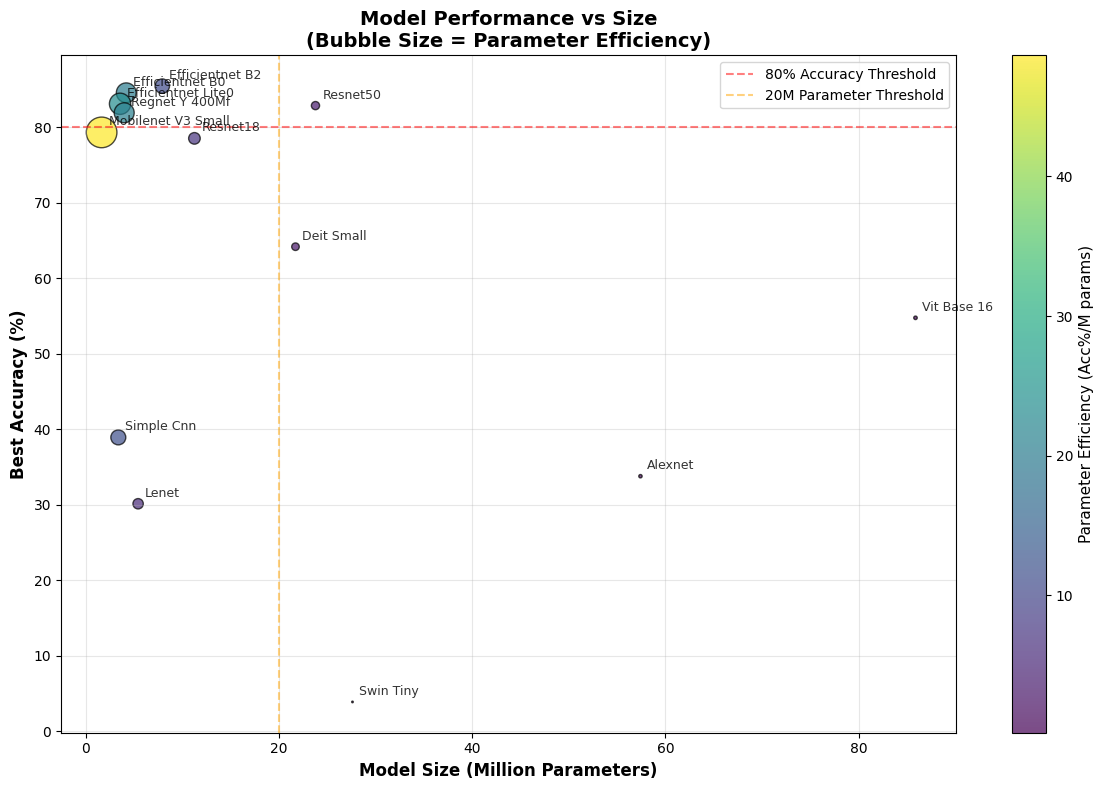

In [17]:
plot_performance_vs_efficiency()                    # Performance vs Efficiency

✅ Loaded analysis data: 13 models
🎨 Creating Learning Efficiency plot...
💾 Saved: /content/drive/MyDrive/CIFAR100_Experiment/plots/analysis/learning_efficiency.png


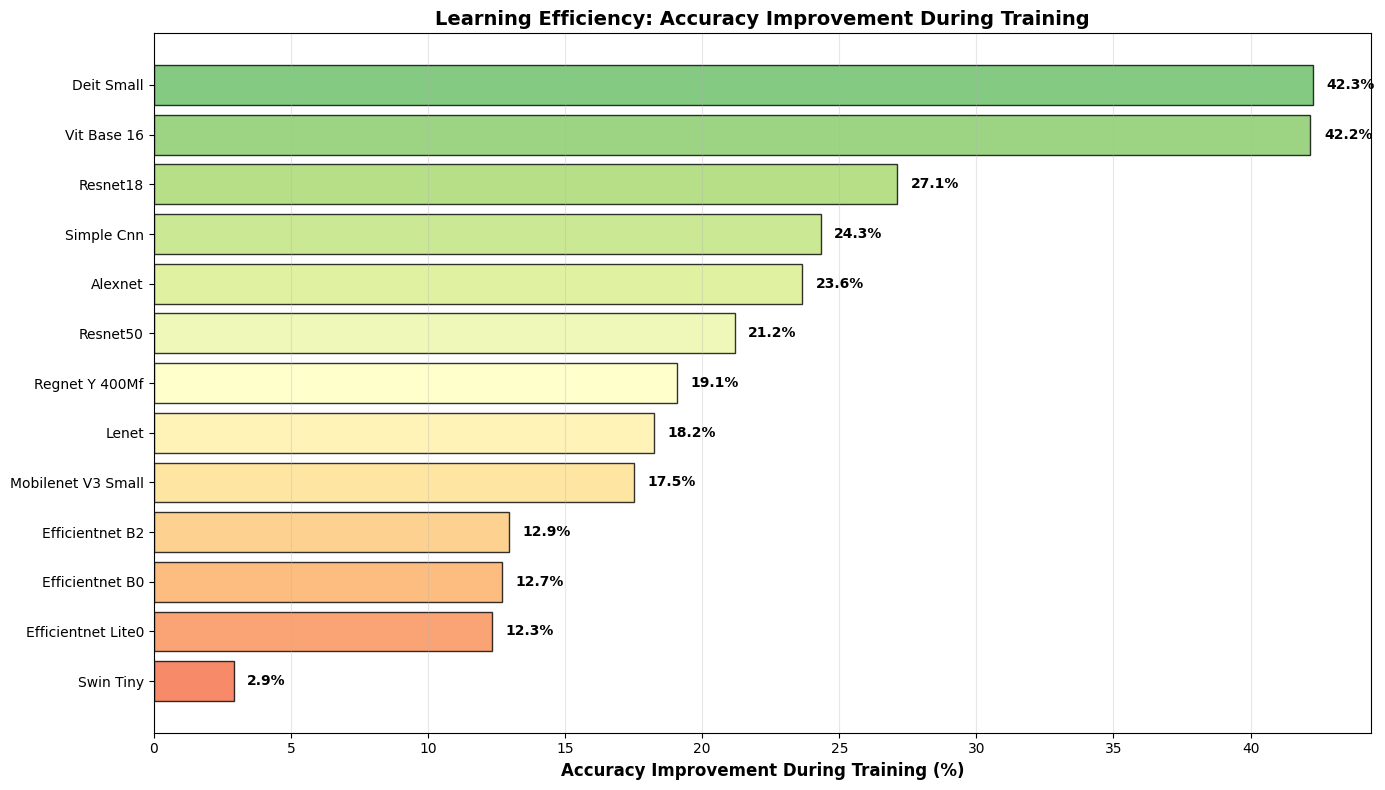

In [18]:
plot_learning_efficiency()                          # Learning Efficiency

✅ Loaded analysis data: 13 models
🎨 Creating Training Stability plot...
💾 Saved: /content/drive/MyDrive/CIFAR100_Experiment/plots/analysis/training_stability.png


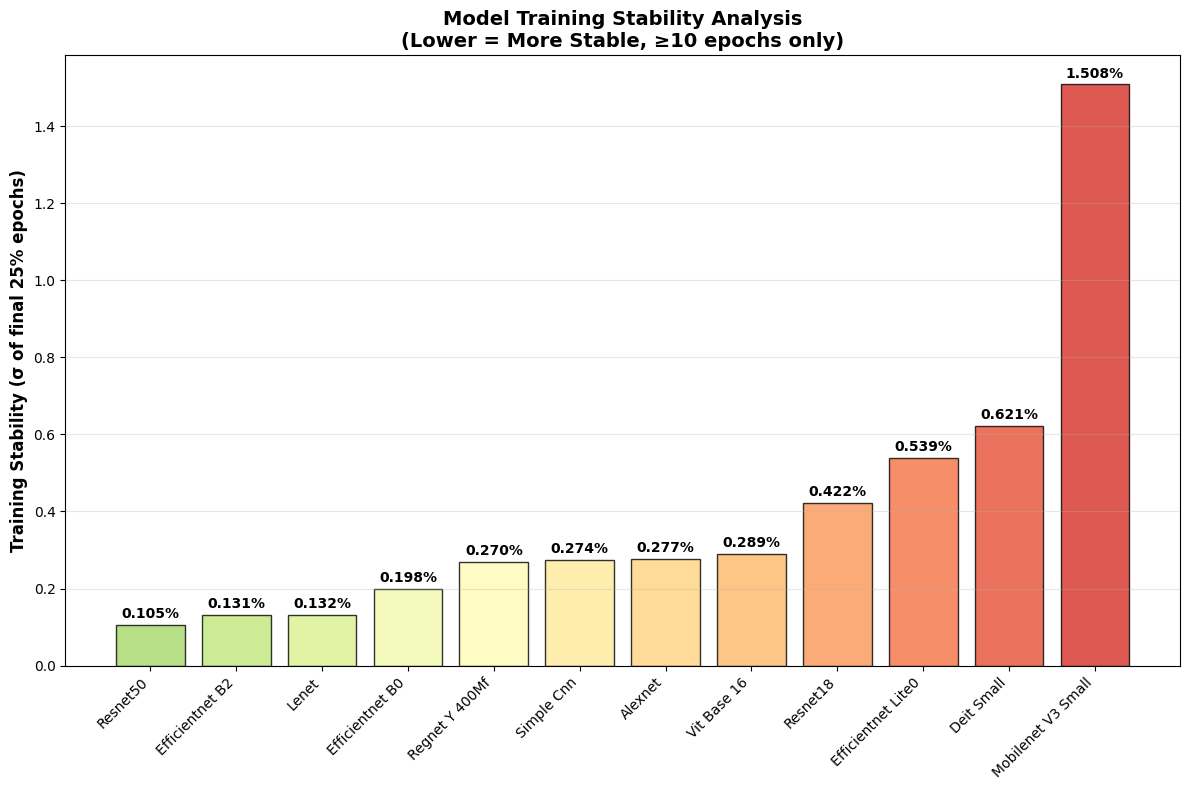

In [19]:
plot_training_stability()                           # Training Stability

✅ Loaded analysis data: 13 models
🎨 Creating Architecture Comparison radar chart...

        'CNN (Traditional)': ['Simple Cnn', 'Lenet', 'Alexnet'],
        'CNN (Modern)': ['Resnet18', 'Resnet50', 'Regnet Y 400Mf'],
        'EfficientNet': ['Efficientnet B0', 'Efficientnet B2', 'Efficientnet Lite0'],
        'Vision Transformers': ['Vit Base 16', 'Deit Small', 'Swin Tiny'],
        'Mobile-Optimized': ['Mobilenet V3 Small']
        
💾 Saved: /content/drive/MyDrive/CIFAR100_Experiment/plots/analysis/architecture_radar.png


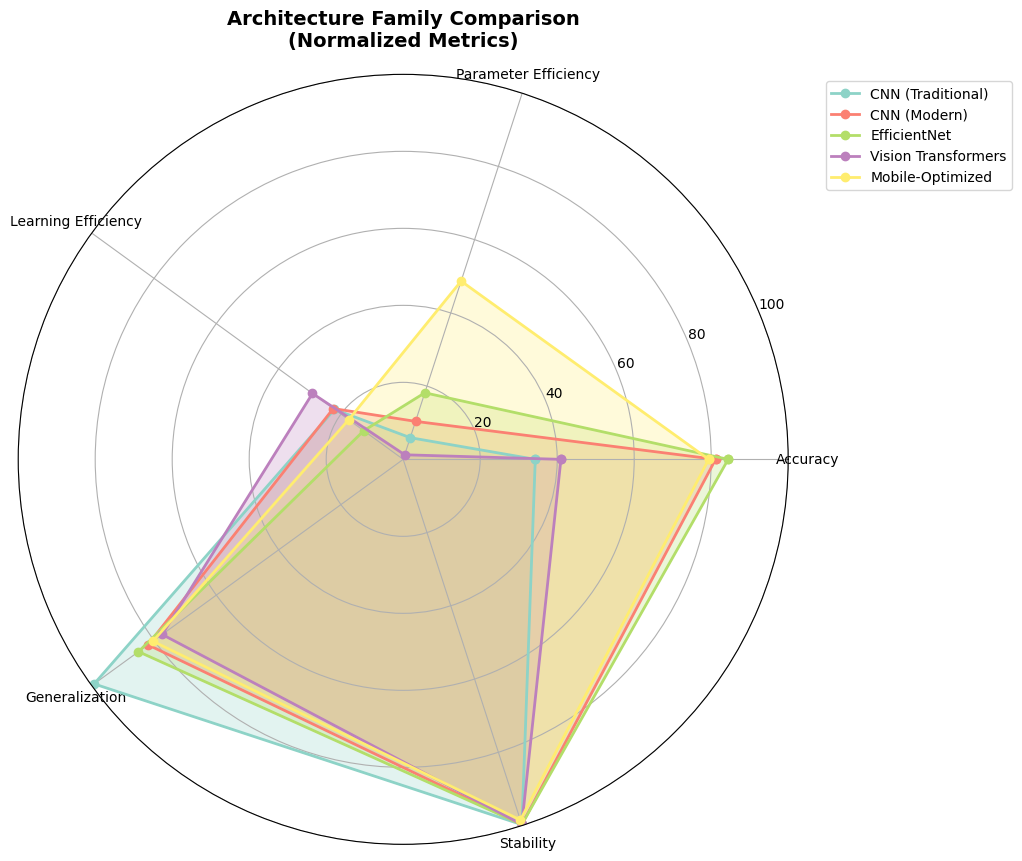

In [20]:
plot_architecture_comparison_radar()                # Architecture Comparison

## 4. Plotting Loss and Accuracy

In [21]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from pathlib import Path
import seaborn as sns

### Extract Loss Curves from Checkpoint

In [22]:
def extract_loss_curves_from_checkpoint(checkpoint_path, model_name=None):
    """
    Extract train and test loss curves from a single checkpoint

    Args:
        checkpoint_path: Path to the .pth checkpoint file
        model_name: Optional model name

    Returns:
        Dictionary with loss curves and metadata
    """
    try:
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location='cpu')

        # Extract model name if not provided
        if model_name is None:
            model_name = Path(checkpoint_path).stem.replace('_checkpoint', '').replace('_best', '')

        # Extract training history
        train_history = checkpoint.get('train_history', {})
        test_history = checkpoint.get('test_history', {})

        if not train_history or not test_history:
            print(f"⚠️ No training history found in {model_name}")
            return None

        # Extract loss curves
        train_losses = train_history.get('loss', [])
        test_losses = test_history.get('loss', [])
        train_accuracies = train_history.get('accuracy', [])
        test_accuracies = test_history.get('accuracy', [])

        if not train_losses or not test_losses:
            print(f"⚠️ No loss curves found in {model_name}")
            return None

        # ✅ HANDLE INFINITY VALUES IN TEST LOSS
        # Replace inf values with NaN for better plotting
        clean_test_losses = []
        has_inf_values = False

        for loss in test_losses:
            if np.isinf(loss) or np.isnan(loss):
                clean_test_losses.append(np.nan)
                has_inf_values = True
            else:
                clean_test_losses.append(loss)

        if has_inf_values:
            print(f"⚠️ {model_name} has infinite/NaN test loss values - likely numerical instability!")

        # Create epochs array
        epochs = list(range(1, len(train_losses) + 1))

        return {
            'model_name': model_name.replace('_', ' ').title(),
            'epochs': epochs,
            'train_loss': train_losses,
            'test_loss': clean_test_losses,  # ✅ Use cleaned test losses
            'train_accuracy': [acc * 100 for acc in train_accuracies],  # Convert to percentage
            'test_accuracy': [acc * 100 for acc in test_accuracies],
            'final_train_loss': train_losses[-1] if train_losses else None,
            'final_test_loss': test_losses[-1] if test_losses else None,  # Keep original for info
            'best_test_acc': max(test_accuracies) * 100 if test_accuracies else None,
            'total_epochs': len(epochs),
            'has_numerical_issues': has_inf_values  # ✅ Flag for analysis
        }

    except Exception as e:
        print(f"❌ Error loading {checkpoint_path}: {e}")
        return None

### Extract all Loss curves

In [23]:
def extract_all_loss_curves(models_dir=None, prefer_best=True):
    """
    Extract loss curves from all model checkpoints

    Args:
        models_dir: Path to models directory (defaults to Drive path)
        prefer_best: If True, use _best.pth files when available

    Returns:
        List of loss curve dictionaries
    """
    if models_dir is None:
        models_dir = f"{DRIVE_BASE_PATH}/models"

    # Find all checkpoint files
    all_files = glob.glob(f"{models_dir}/*.pth")

    # Group files by model name (avoid duplicates)
    models = {}
    for file_path in all_files:
        file_name = Path(file_path).stem

        if file_name.endswith('_best'):
            model_name = file_name[:-5]
            file_type = 'best'
        elif file_name.endswith('_checkpoint'):
            model_name = file_name[:-11]
            file_type = 'checkpoint'
        else:
            continue

        if model_name not in models:
            models[model_name] = {}
        models[model_name][file_type] = file_path

    print(f"📂 Found {len(models)} unique models for loss curve extraction")

    # Extract loss curves
    all_curves = []
    for model_name, files in models.items():
        # Prefer best checkpoint over regular checkpoint
        if prefer_best and 'best' in files:
            checkpoint_path = files['best']
        elif 'checkpoint' in files:
            checkpoint_path = files['checkpoint']
        else:
            continue

        curves = extract_loss_curves_from_checkpoint(checkpoint_path, model_name)
        if curves:
            all_curves.append(curves)
            print(f"✅ Extracted curves for {curves['model_name']} ({curves['total_epochs']} epochs)")

    return all_curves

### Plot individual Loss curves

In [24]:
def plot_individual_loss_curves(curves_data, save_dir=None, figsize=(15, 10)):
    """
    Plot individual loss curves for each model (one plot per model)

    Args:
        curves_data: List of curve dictionaries from extract_all_loss_curves()
        save_dir: Directory to save plots
        figsize: Figure size for each plot
    """
    if save_dir:
        Path(save_dir).mkdir(parents=True, exist_ok=True)

    for curves in curves_data:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        model_name = curves['model_name']
        epochs = curves['epochs']

        # ✅ IMPROVED LOSS PLOT WITH INFINITY HANDLING
        ax1.plot(epochs, curves['train_loss'], 'b-', linewidth=2, label='Train Loss', alpha=0.8)

        # Handle test loss with potential infinity values
        if curves.get('has_numerical_issues', False):
            # Plot with warning for numerical issues
            ax1.plot(epochs, curves['test_loss'], 'r--', linewidth=2,
                    label='Test Loss (⚠️ Numerical Issues)', alpha=0.8)
            ax1.set_title(f'{model_name} - Loss Curves (⚠️ Test Loss: Numerical Instability)',
                         fontweight='bold', fontsize=14, color='red')
        else:
            ax1.plot(epochs, curves['test_loss'], 'r-', linewidth=2, label='Test Loss', alpha=0.8)
            ax1.set_title(f'{model_name} - Loss Curves', fontweight='bold', fontsize=14)

        ax1.set_xlabel('Epoch', fontweight='bold')
        ax1.set_ylabel('Loss', fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Add final loss values as text with infinity handling
        final_train = curves['final_train_loss']
        final_test = curves['final_test_loss']

        if np.isinf(final_test):
            loss_text = f'Final Train Loss: {final_train:.4f}\\nFinal Test Loss: ∞ (Numerical Issue)'
            text_color = 'red'
        else:
            loss_text = f'Final Train Loss: {final_train:.4f}\\nFinal Test Loss: {final_test:.4f}'
            text_color = 'black'

        ax1.text(0.02, 0.98, loss_text, transform=ax1.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), color=text_color)

        # Plot 2: Accuracy curves
        ax2.plot(epochs, curves['train_accuracy'], 'b-', linewidth=2, label='Train Accuracy', alpha=0.8)
        ax2.plot(epochs, curves['test_accuracy'], 'r-', linewidth=2, label='Test Accuracy', alpha=0.8)
        ax2.set_xlabel('Epoch', fontweight='bold')
        ax2.set_ylabel('Accuracy (%)', fontweight='bold')
        ax2.set_title(f'{model_name} - Accuracy Curves', fontweight='bold', fontsize=14)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Add best accuracy as text
        best_acc = curves['best_test_acc']
        ax2.text(0.02, 0.02, f'Best Test Accuracy: {best_acc:.2f}%',
                transform=ax2.transAxes, verticalalignment='bottom',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

        # ✅ ADD ANALYSIS TEXT BOX FOR MODELS WITH ISSUES
        if curves.get('has_numerical_issues', False):
            analysis_text = ("⚠️ ANALYSIS: ∞ indicates numerical instability | Model still learns (accuracy improves) but loss calculation fails")

            ax2.text(0.98, 0.98, analysis_text, transform=ax2.transAxes,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9),
                    fontsize=9, color='red')

        plt.tight_layout()

        if save_dir:
            filename = f"{model_name.lower().replace(' ', '_')}_curves.png"
            save_path = Path(save_dir) / filename
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"💾 Saved: {save_path}")

        plt.show()

### Plot combined Loss curves

In [25]:
def plot_combined_loss_curves(curves_data, save_path=None, figsize=(16, 12)):
    """
    Plot all models' loss curves in a single comprehensive plot

    Args:
        curves_data: List of curve dictionaries from extract_all_loss_curves()
        save_path: Path to save the combined plot
        figsize: Figure size
    """
    # Filter out models with very few epochs for clarity
    valid_curves = [c for c in curves_data if c['total_epochs'] >= 5]

    if len(valid_curves) == 0:
        print("❌ No valid curves to plot")
        return

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)

    # Color palette
    colors = plt.cm.tab20(np.linspace(0, 1, len(valid_curves)))

    # Plot 1: All Train Loss curves
    for i, curves in enumerate(valid_curves):
        ax1.plot(curves['epochs'], curves['train_loss'],
                color=colors[i], linewidth=2, alpha=0.7, label=curves['model_name'])
    ax1.set_xlabel('Epoch', fontweight='bold')
    ax1.set_ylabel('Training Loss', fontweight='bold')
    ax1.set_title('Training Loss Curves - All Models', fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

    # Plot 2: All Test Loss curves
    for i, curves in enumerate(valid_curves):
        ax2.plot(curves['epochs'], curves['test_loss'],
                color=colors[i], linewidth=2, alpha=0.7, label=curves['model_name'])
    ax2.set_xlabel('Epoch', fontweight='bold')
    ax2.set_ylabel('Test Loss', fontweight='bold')
    ax2.set_title('Test Loss Curves - All Models', fontweight='bold', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

    # Plot 3: All Train Accuracy curves
    for i, curves in enumerate(valid_curves):
        ax3.plot(curves['epochs'], curves['train_accuracy'],
                color=colors[i], linewidth=2, alpha=0.7, label=curves['model_name'])
    ax3.set_xlabel('Epoch', fontweight='bold')
    ax3.set_ylabel('Training Accuracy (%)', fontweight='bold')
    ax3.set_title('Training Accuracy Curves - All Models', fontweight='bold', fontsize=14)
    ax3.grid(True, alpha=0.3)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

    # Plot 4: All Test Accuracy curves
    for i, curves in enumerate(valid_curves):
        ax4.plot(curves['epochs'], curves['test_accuracy'],
                color=colors[i], linewidth=2, alpha=0.7, label=curves['model_name'])
    ax4.set_xlabel('Epoch', fontweight='bold')
    ax4.set_ylabel('Test Accuracy (%)', fontweight='bold')
    ax4.set_title('Test Accuracy Curves - All Models', fontweight='bold', fontsize=14)
    ax4.grid(True, alpha=0.3)
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Saved combined plot: {save_path}")

    plt.show()

### Plot Top Perfoming Models

In [26]:
def plot_top_performers_comparison(curves_data, top_n=5, save_path=None, figsize=(14, 10)):
    """
    Plot comparison of top N performing models

    Args:
        curves_data: List of curve dictionaries
        top_n: Number of top models to compare
        save_path: Path to save the plot
        figsize: Figure size
    """
    # Sort by best accuracy and take top N
    sorted_curves = sorted(curves_data, key=lambda x: x['best_test_acc'], reverse=True)
    top_curves = sorted_curves[:top_n]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Color palette
    colors = plt.cm.Set1(np.linspace(0, 1, len(top_curves)))

    # Plot 1: Test Loss comparison
    for i, curves in enumerate(top_curves):
        ax1.plot(curves['epochs'], curves['test_loss'],
                color=colors[i], linewidth=3, alpha=0.8,
                label=f"{curves['model_name']} ({curves['best_test_acc']:.1f}%)")

    ax1.set_xlabel('Epoch', fontweight='bold')
    ax1.set_ylabel('Test Loss', fontweight='bold')
    ax1.set_title(f'Top {top_n} Models - Test Loss Comparison', fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot 2: Test Accuracy comparison
    for i, curves in enumerate(top_curves):
        ax2.plot(curves['epochs'], curves['test_accuracy'],
                color=colors[i], linewidth=3, alpha=0.8,
                label=f"{curves['model_name']} ({curves['best_test_acc']:.1f}%)")

    ax2.set_xlabel('Epoch', fontweight='bold')
    ax2.set_ylabel('Test Accuracy (%)', fontweight='bold')
    ax2.set_title(f'Top {top_n} Models - Test Accuracy Comparison', fontweight='bold', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Saved top performers plot: {save_path}")

    plt.show()

### Create all Loss curves plots

In [27]:
def create_all_loss_curve_plots(models_dir=None, save_dir=None):
    """
    Create all loss curve visualizations

    Args:
        models_dir: Directory containing model checkpoints
        save_dir: Directory to save plots
    """
    # Set up save directory
    if save_dir is None:
        save_dir = f"{DRIVE_BASE_PATH}/plots/loss_curves"
        Path(save_dir).mkdir(parents=True, exist_ok=True)

    print("📈 EXTRACTING LOSS CURVES FROM ALL MODELS")
    print("=" * 60)

    # Extract all loss curves
    curves_data = extract_all_loss_curves(models_dir)

    if not curves_data:
        print("❌ No loss curves found!")
        return

    print(f"\\n✅ Successfully extracted curves from {len(curves_data)} models")

    # Create individual plots
    print("\\n🎨 Creating individual loss curve plots...")
    individual_dir = f"{save_dir}/individual"
    plot_individual_loss_curves(curves_data, individual_dir)

    # Create combined plot
    print("\\n🎨 Creating combined loss curves plot...")
    combined_path = f"{save_dir}/all_models_combined.png"
    plot_combined_loss_curves(curves_data, combined_path)

    # Create top performers comparison
    print("\\n🎨 Creating top performers comparison...")
    top_performers_path = f"{save_dir}/top_performers_comparison.png"
    plot_top_performers_comparison(curves_data, top_n=5, save_path=top_performers_path)

    print("\\n✅ All loss curve plots completed!")
    print(f"📂 Plots saved to: {save_dir}")

    return curves_data

### Options to run:
- Create all loss curve plots
    - curves_data = create_all_loss_curve_plots()

- curves_data = extract_all_loss_curves()
- plot_combined_loss_curves(curves_data)
- plot_top_performers_comparison(curves_data, top_n=3)

📈 EXTRACTING LOSS CURVES FROM ALL MODELS
📂 Found 13 unique models for loss curve extraction
✅ Extracted curves for Simple Cnn (19 epochs)
✅ Extracted curves for Lenet (23 epochs)
✅ Extracted curves for Alexnet (20 epochs)
✅ Extracted curves for Resnet18 (15 epochs)
✅ Extracted curves for Efficientnet B0 (15 epochs)
⚠️ mobilenet_v3_small has infinite/NaN test loss values - likely numerical instability!
✅ Extracted curves for Mobilenet V3 Small (15 epochs)
✅ Extracted curves for Resnet50 (19 epochs)
✅ Extracted curves for Efficientnet B2 (19 epochs)
✅ Extracted curves for Regnet Y 400Mf (15 epochs)
✅ Extracted curves for Vit Base 16 (18 epochs)
✅ Extracted curves for Deit Small (17 epochs)
⚠️ efficientnet_lite0 has infinite/NaN test loss values - likely numerical instability!
✅ Extracted curves for Efficientnet Lite0 (14 epochs)
✅ Extracted curves for Swin Tiny (4 epochs)
\n✅ Successfully extracted curves from 13 models
\n🎨 Creating individual loss curve plots...
💾 Saved: /content/drive/

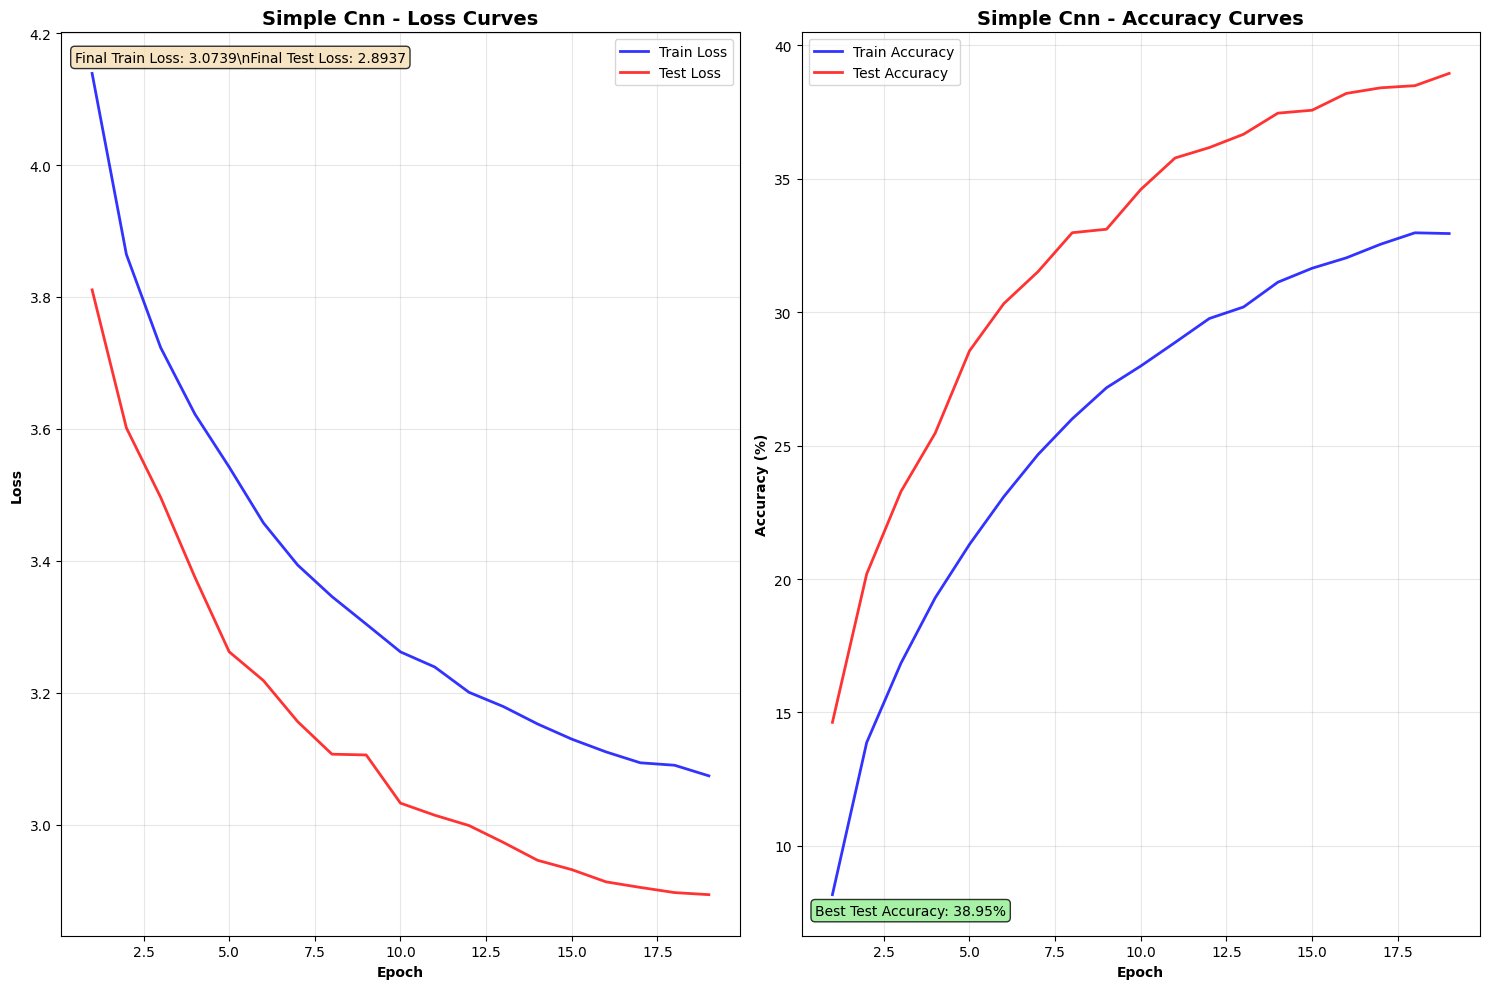

💾 Saved: /content/drive/MyDrive/CIFAR100_Experiment/plots/loss_curves/individual/lenet_curves.png


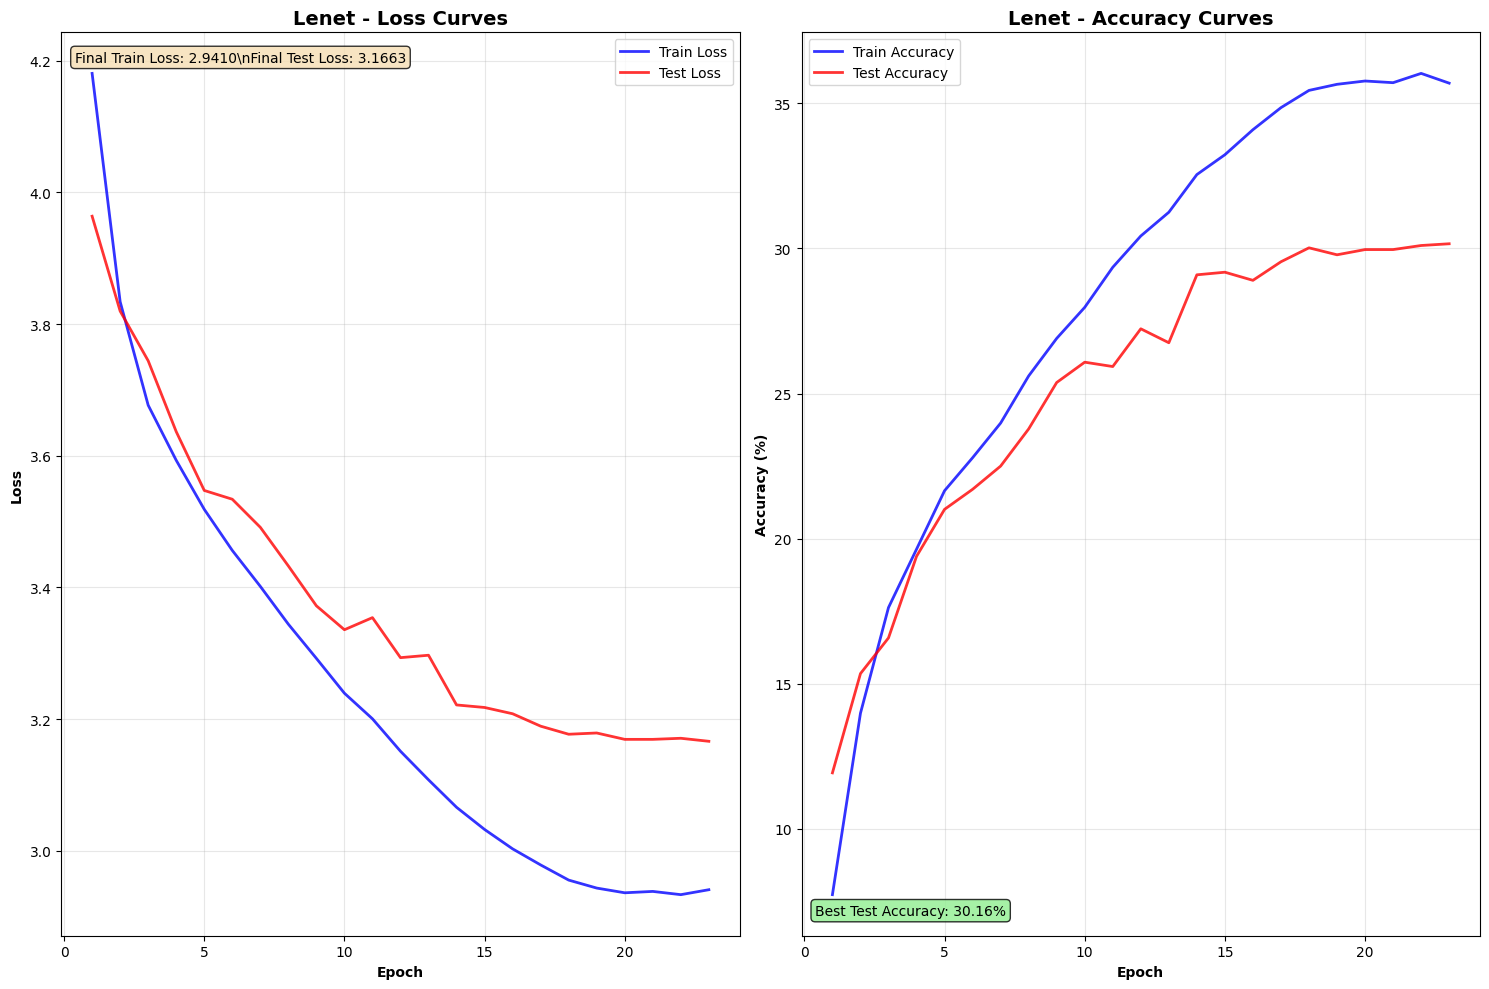

💾 Saved: /content/drive/MyDrive/CIFAR100_Experiment/plots/loss_curves/individual/alexnet_curves.png


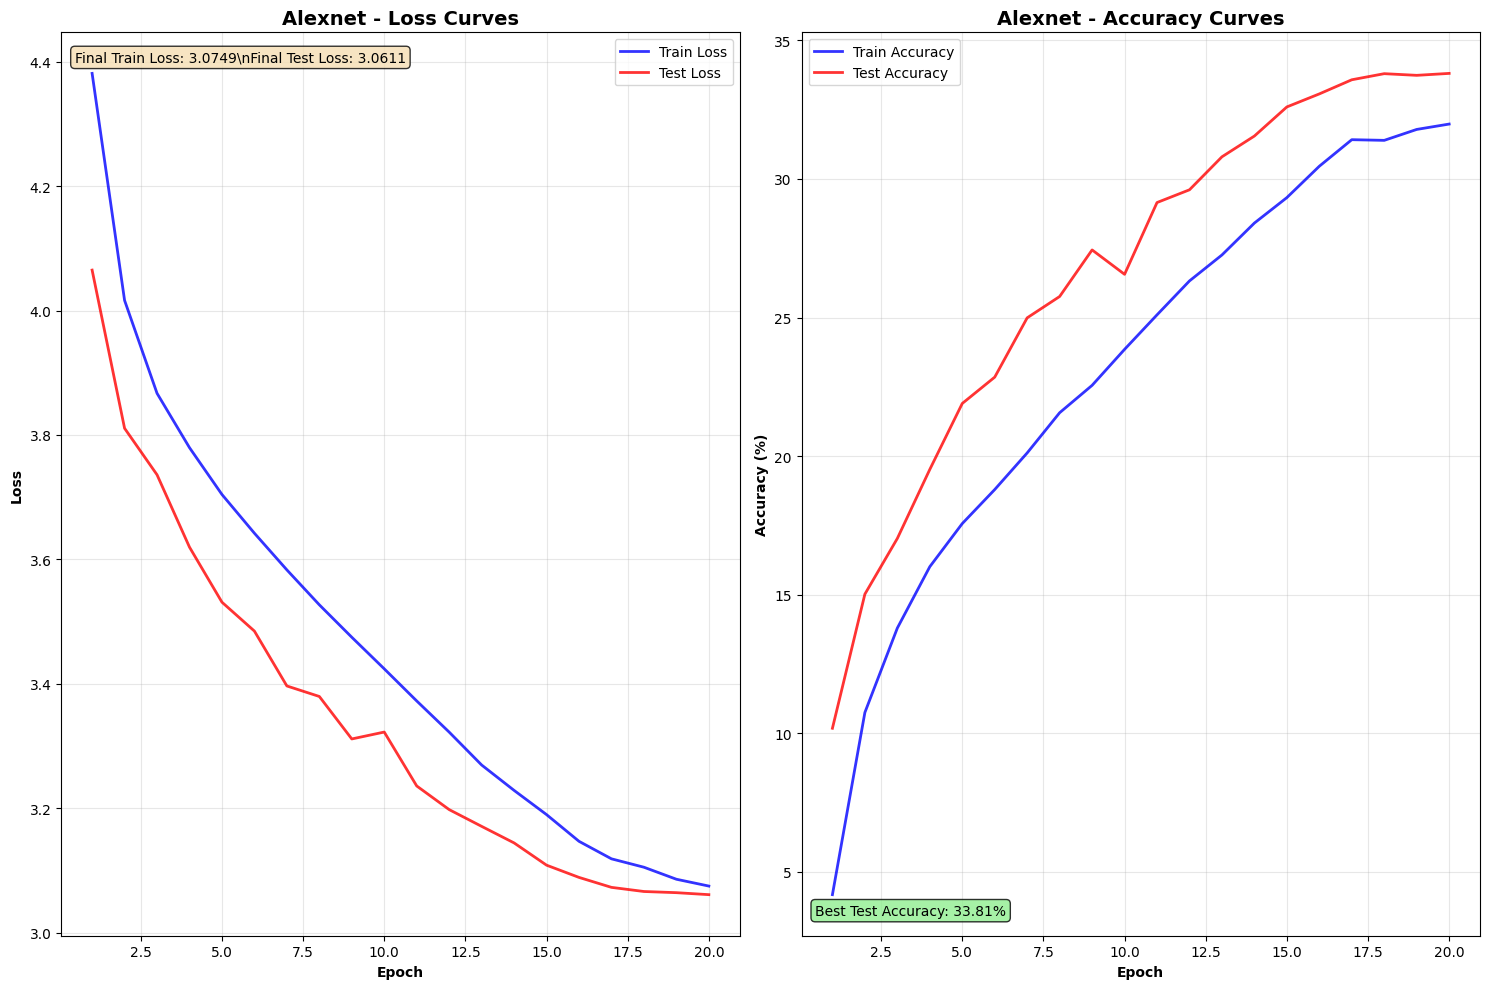

💾 Saved: /content/drive/MyDrive/CIFAR100_Experiment/plots/loss_curves/individual/resnet18_curves.png


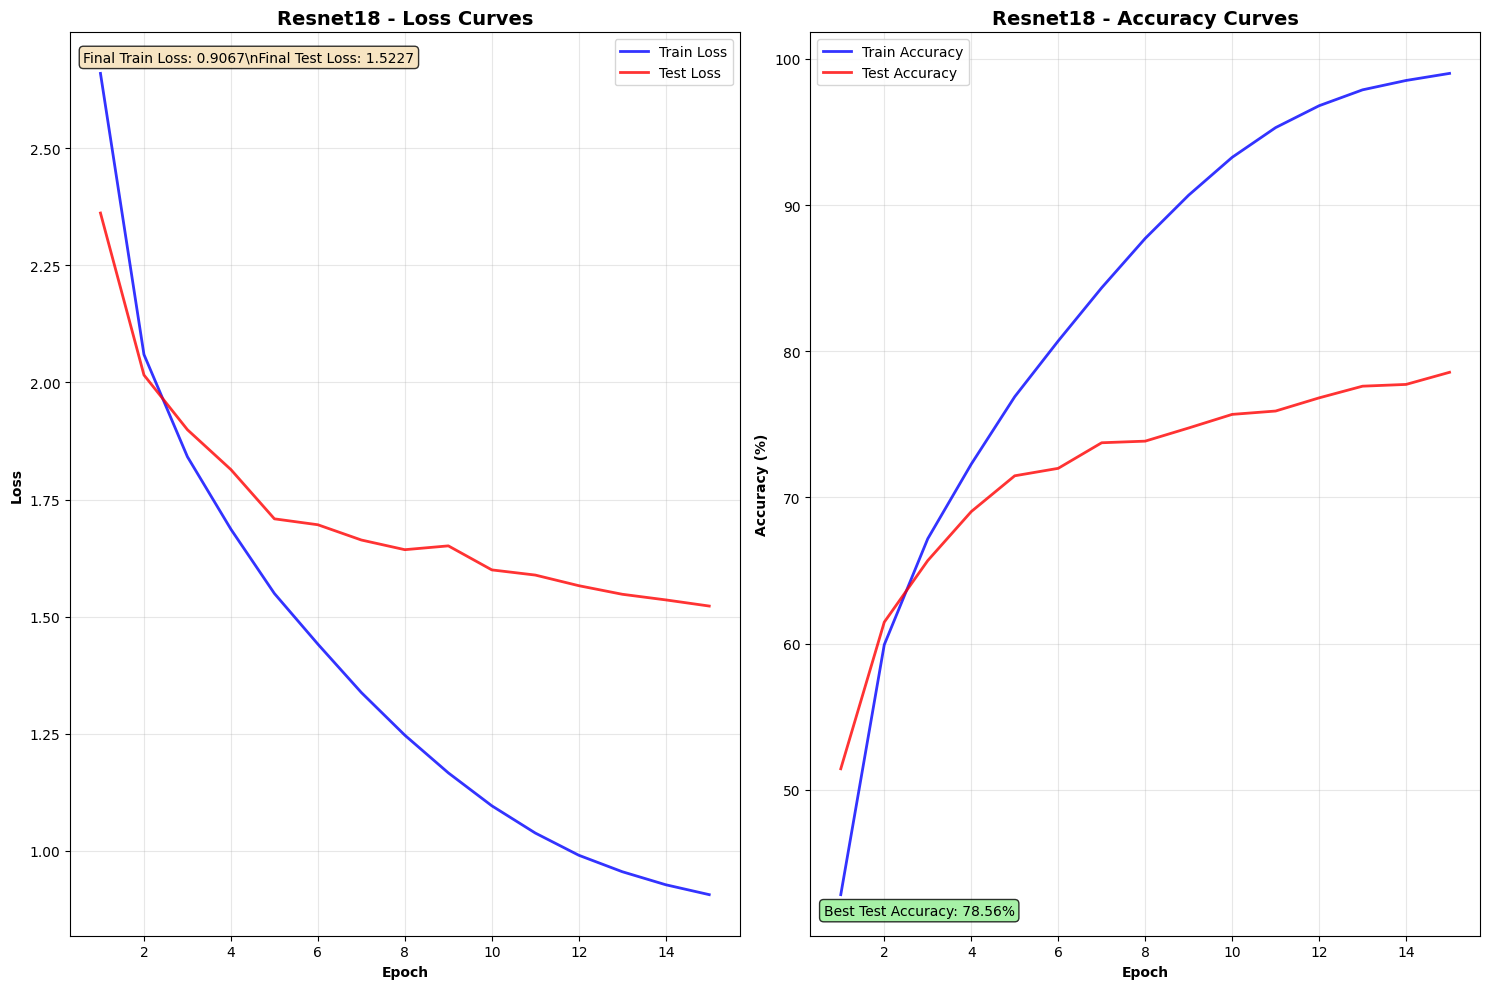

💾 Saved: /content/drive/MyDrive/CIFAR100_Experiment/plots/loss_curves/individual/efficientnet_b0_curves.png


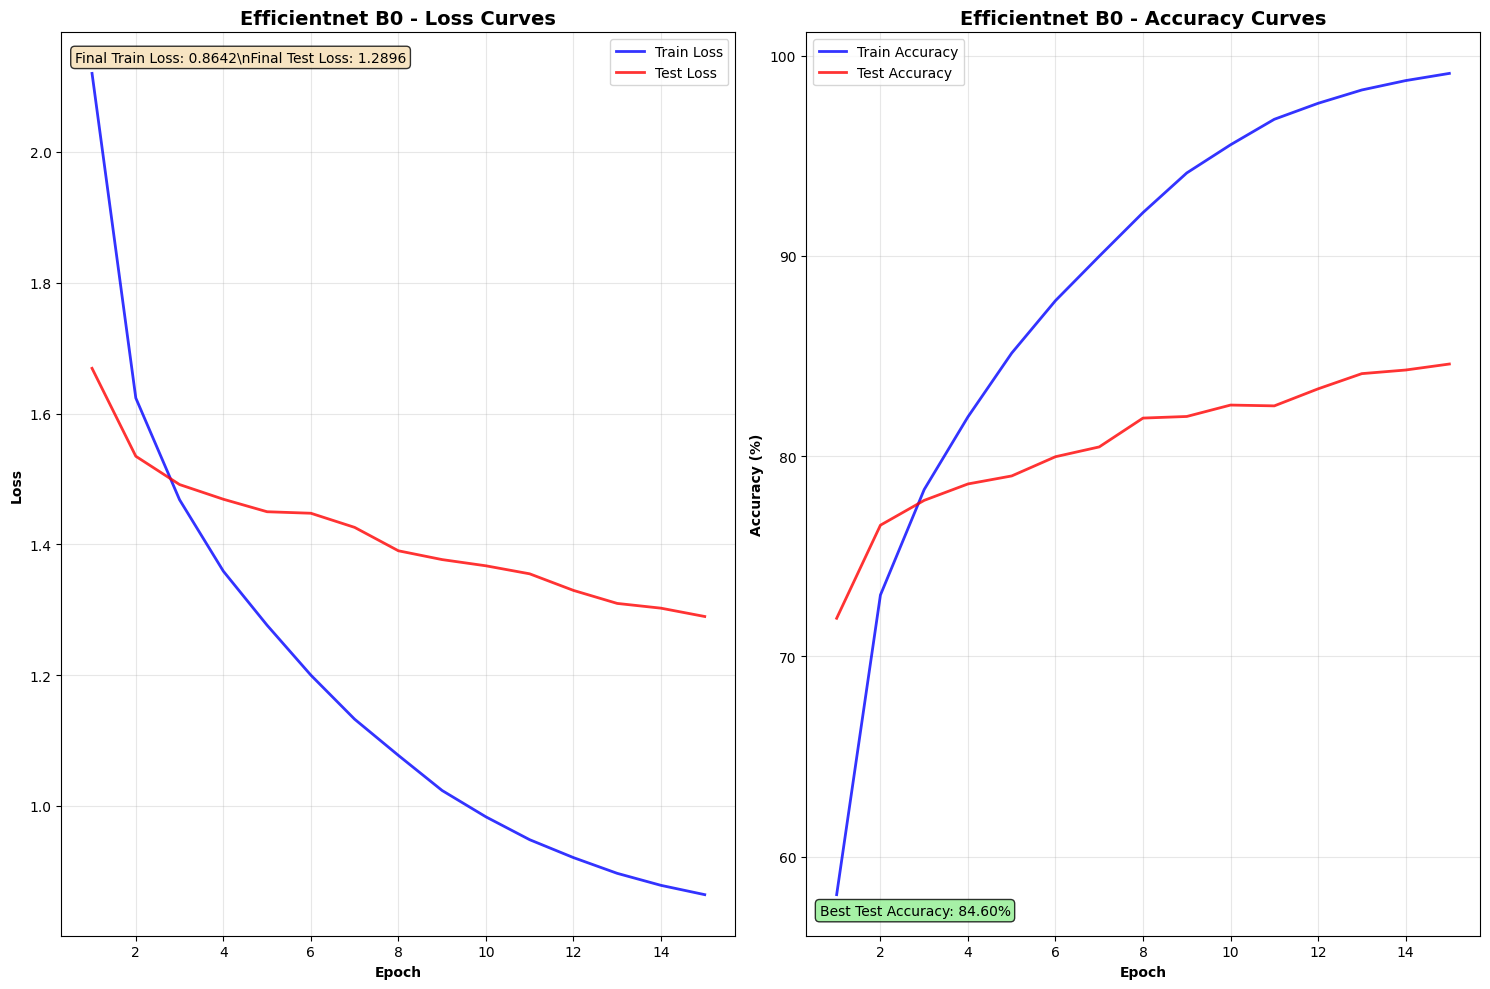

💾 Saved: /content/drive/MyDrive/CIFAR100_Experiment/plots/loss_curves/individual/mobilenet_v3_small_curves.png


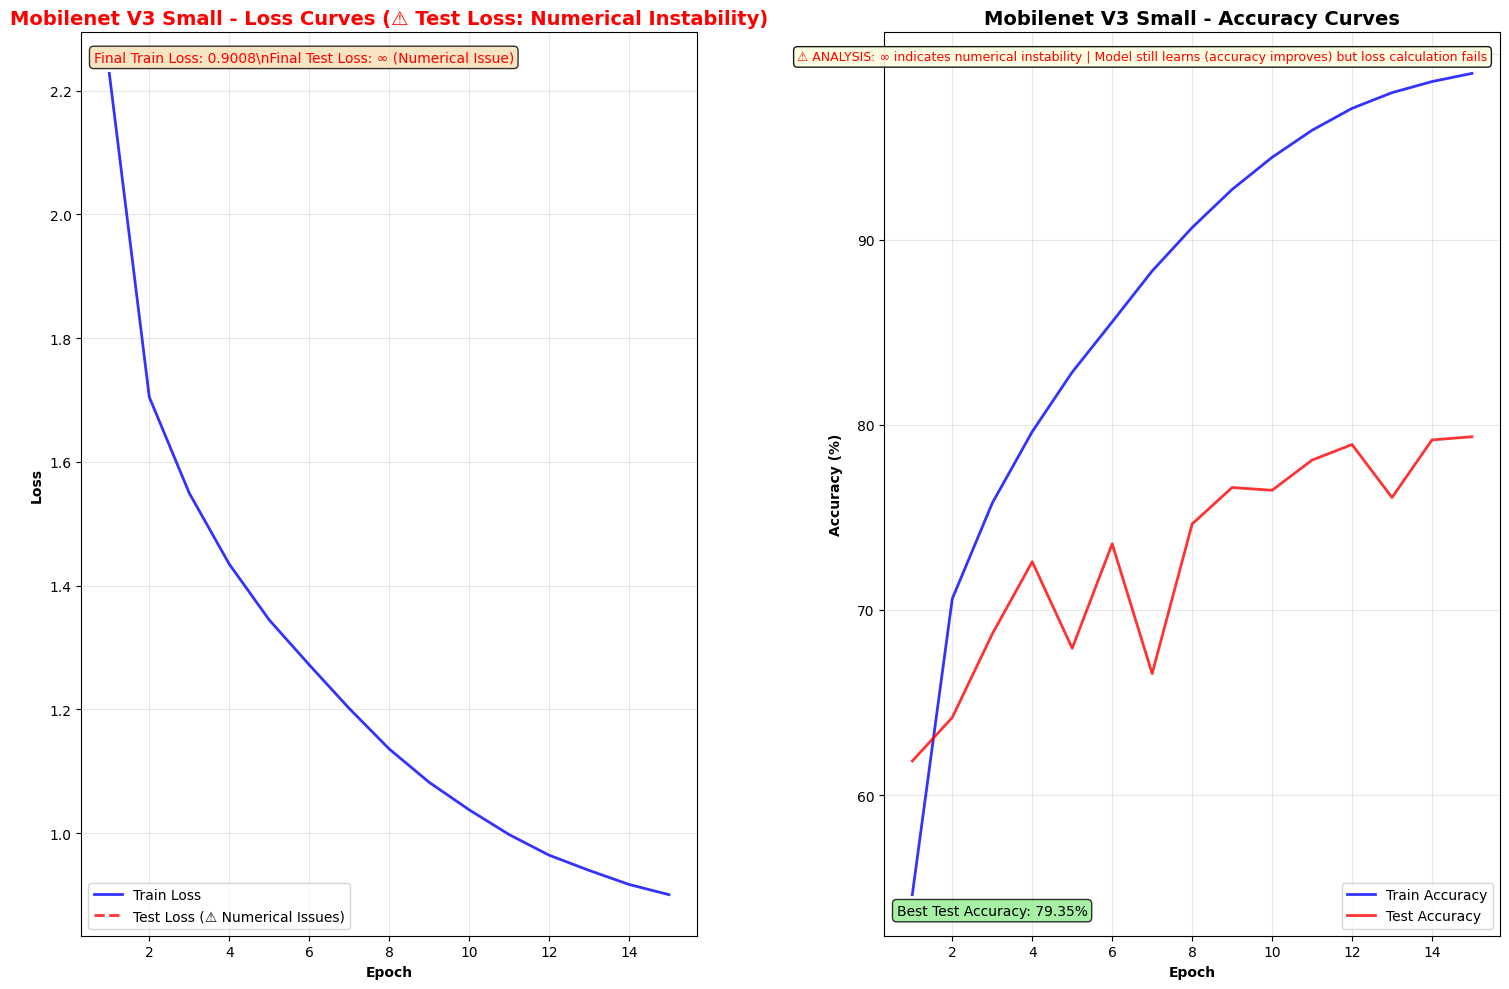

💾 Saved: /content/drive/MyDrive/CIFAR100_Experiment/plots/loss_curves/individual/resnet50_curves.png


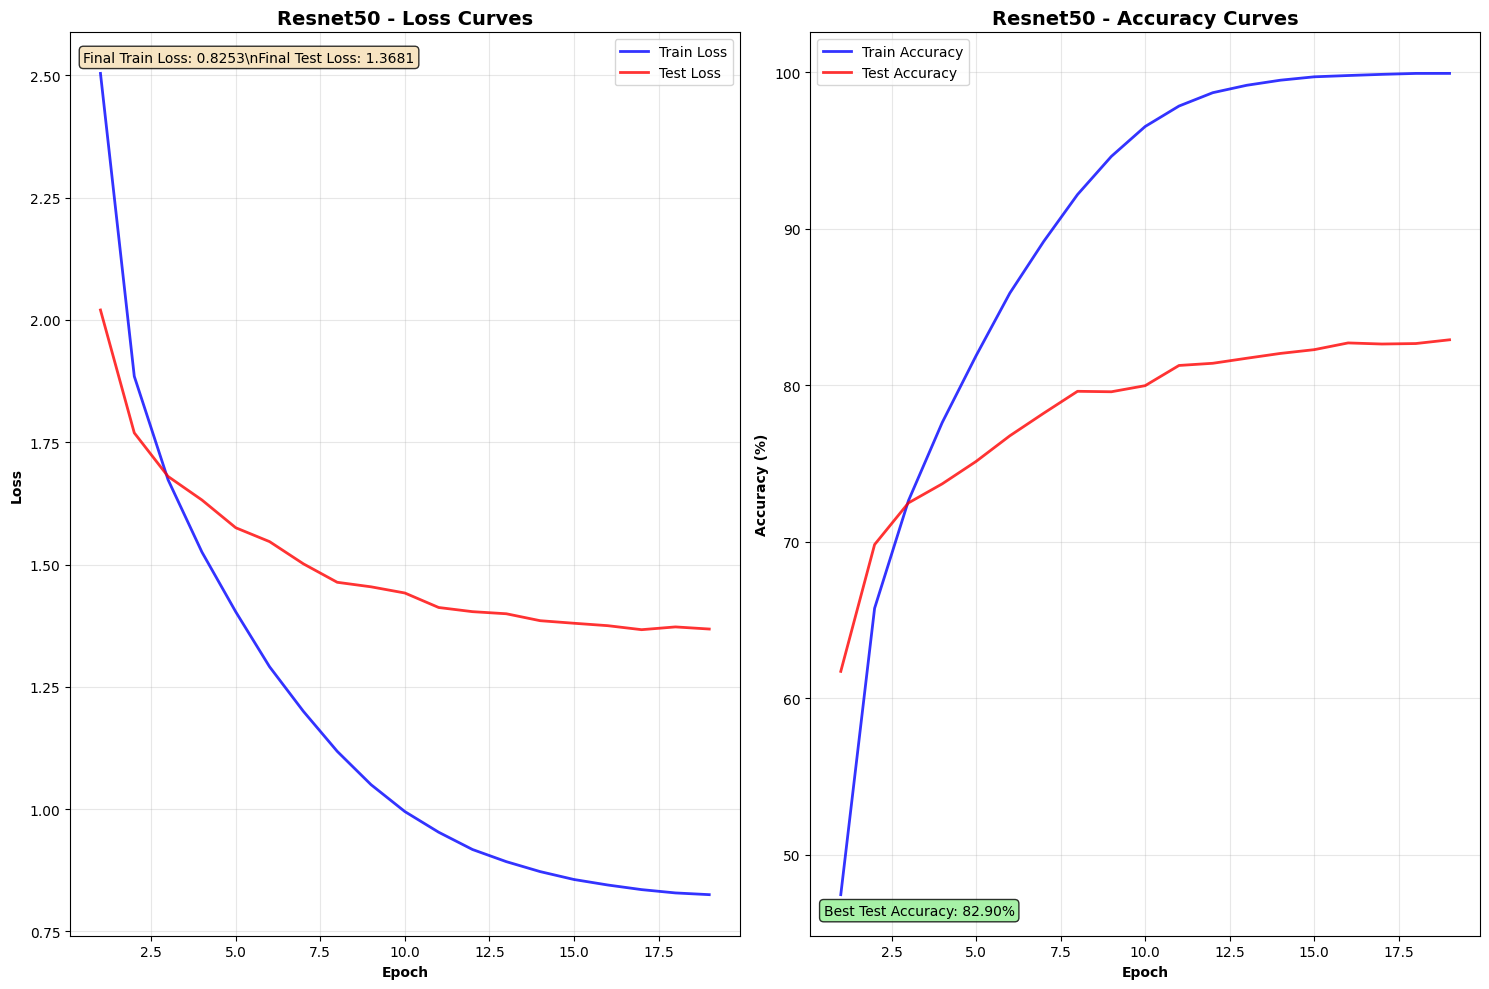

💾 Saved: /content/drive/MyDrive/CIFAR100_Experiment/plots/loss_curves/individual/efficientnet_b2_curves.png


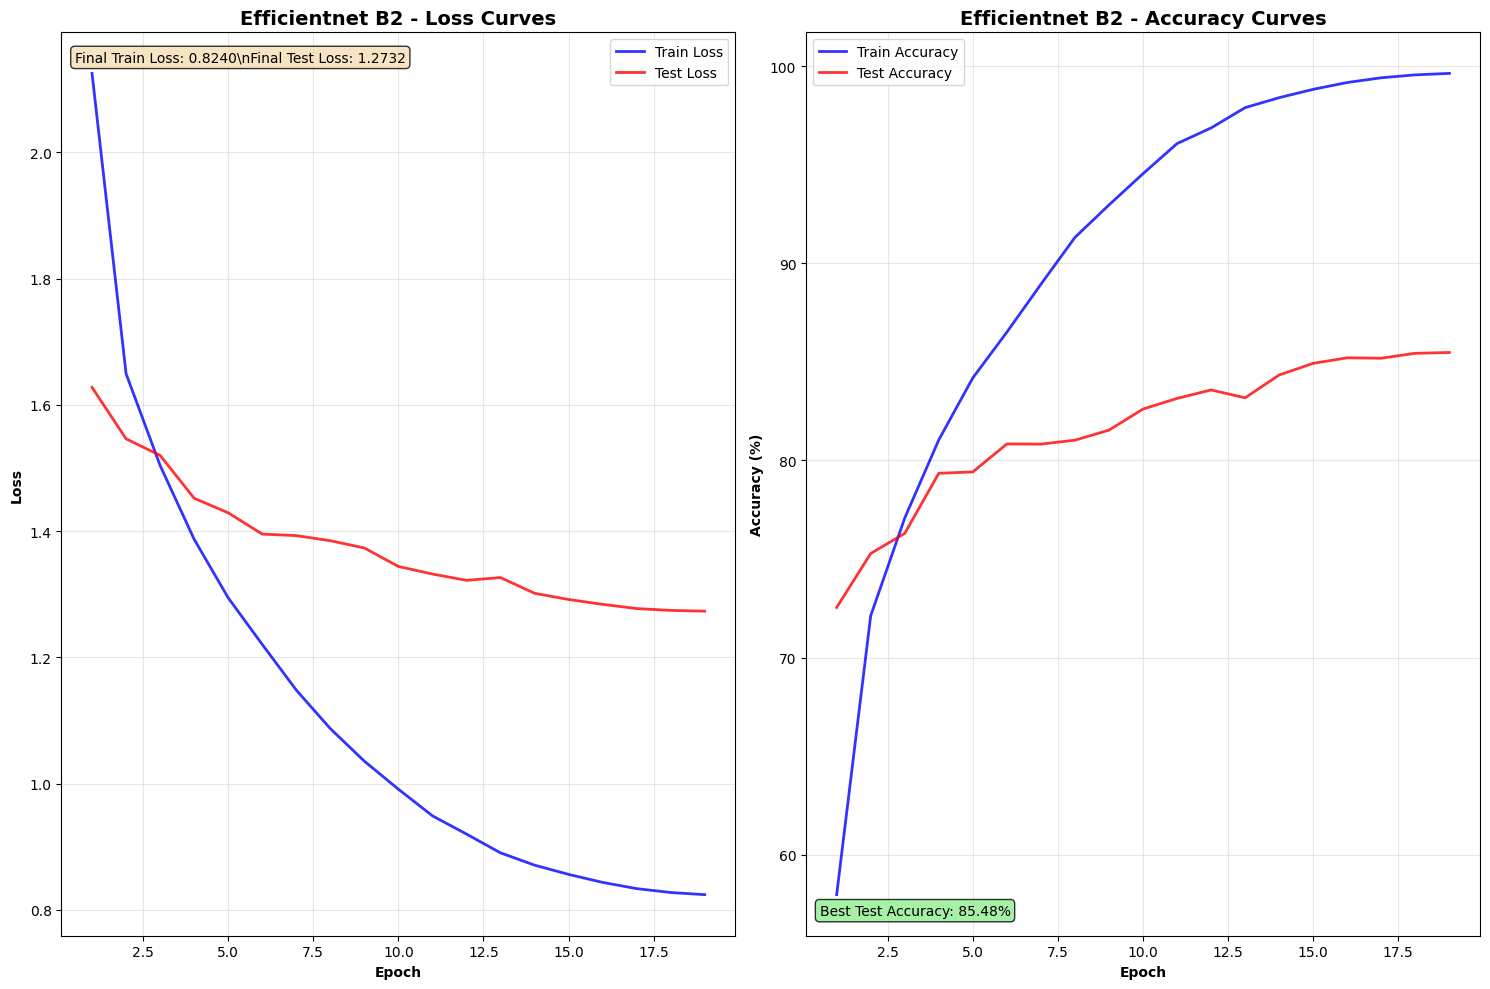

💾 Saved: /content/drive/MyDrive/CIFAR100_Experiment/plots/loss_curves/individual/regnet_y_400mf_curves.png


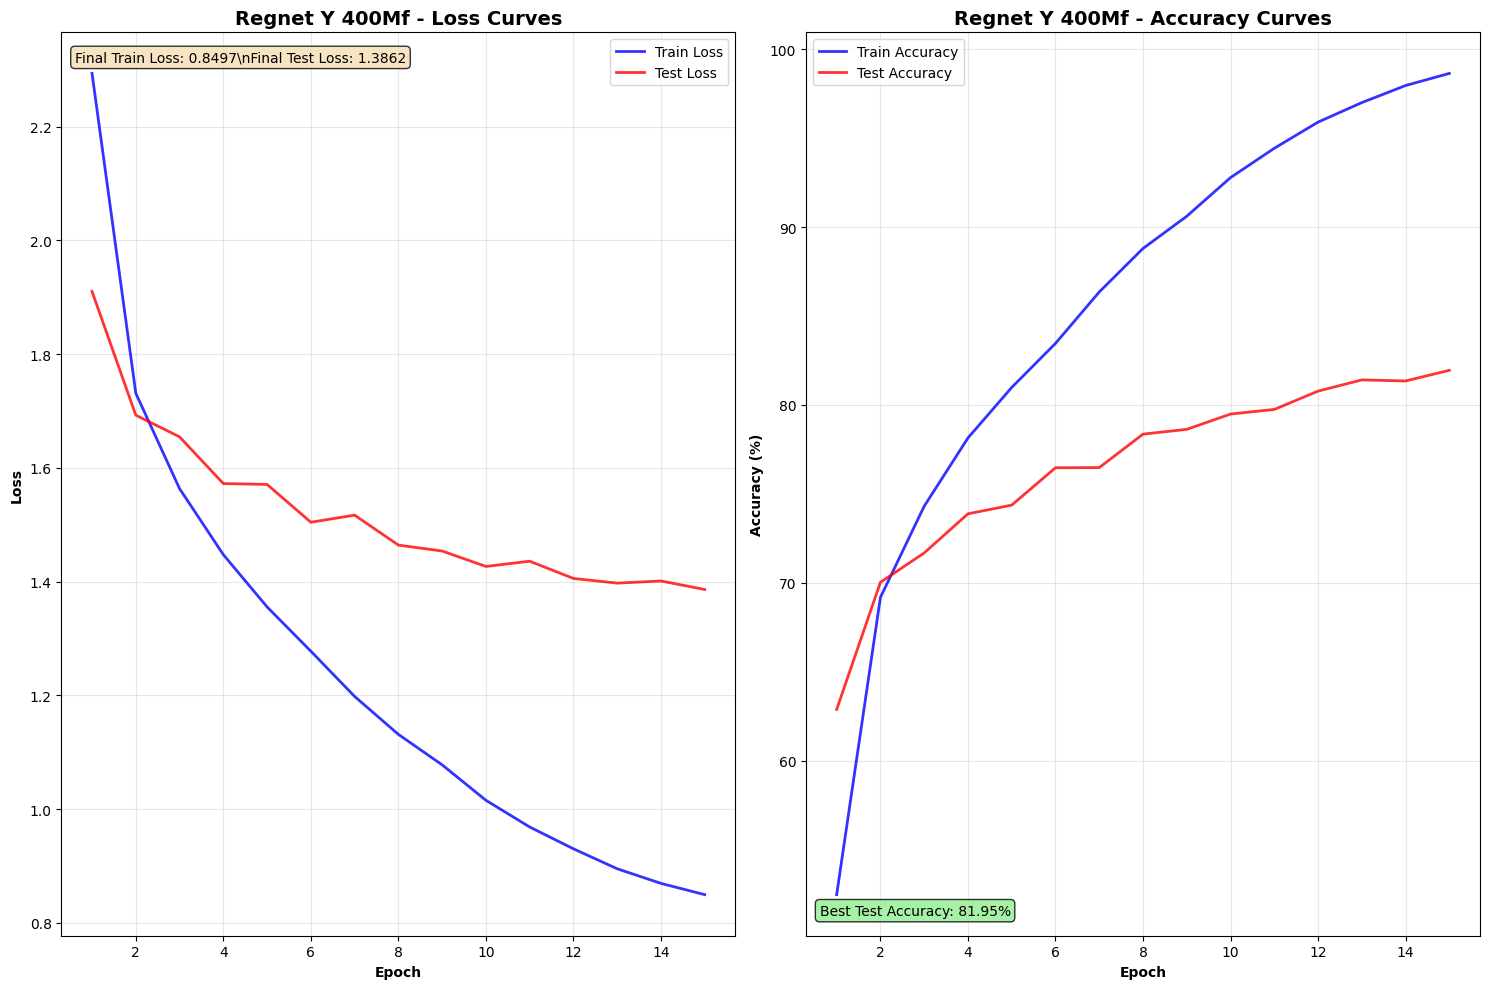

💾 Saved: /content/drive/MyDrive/CIFAR100_Experiment/plots/loss_curves/individual/vit_base_16_curves.png


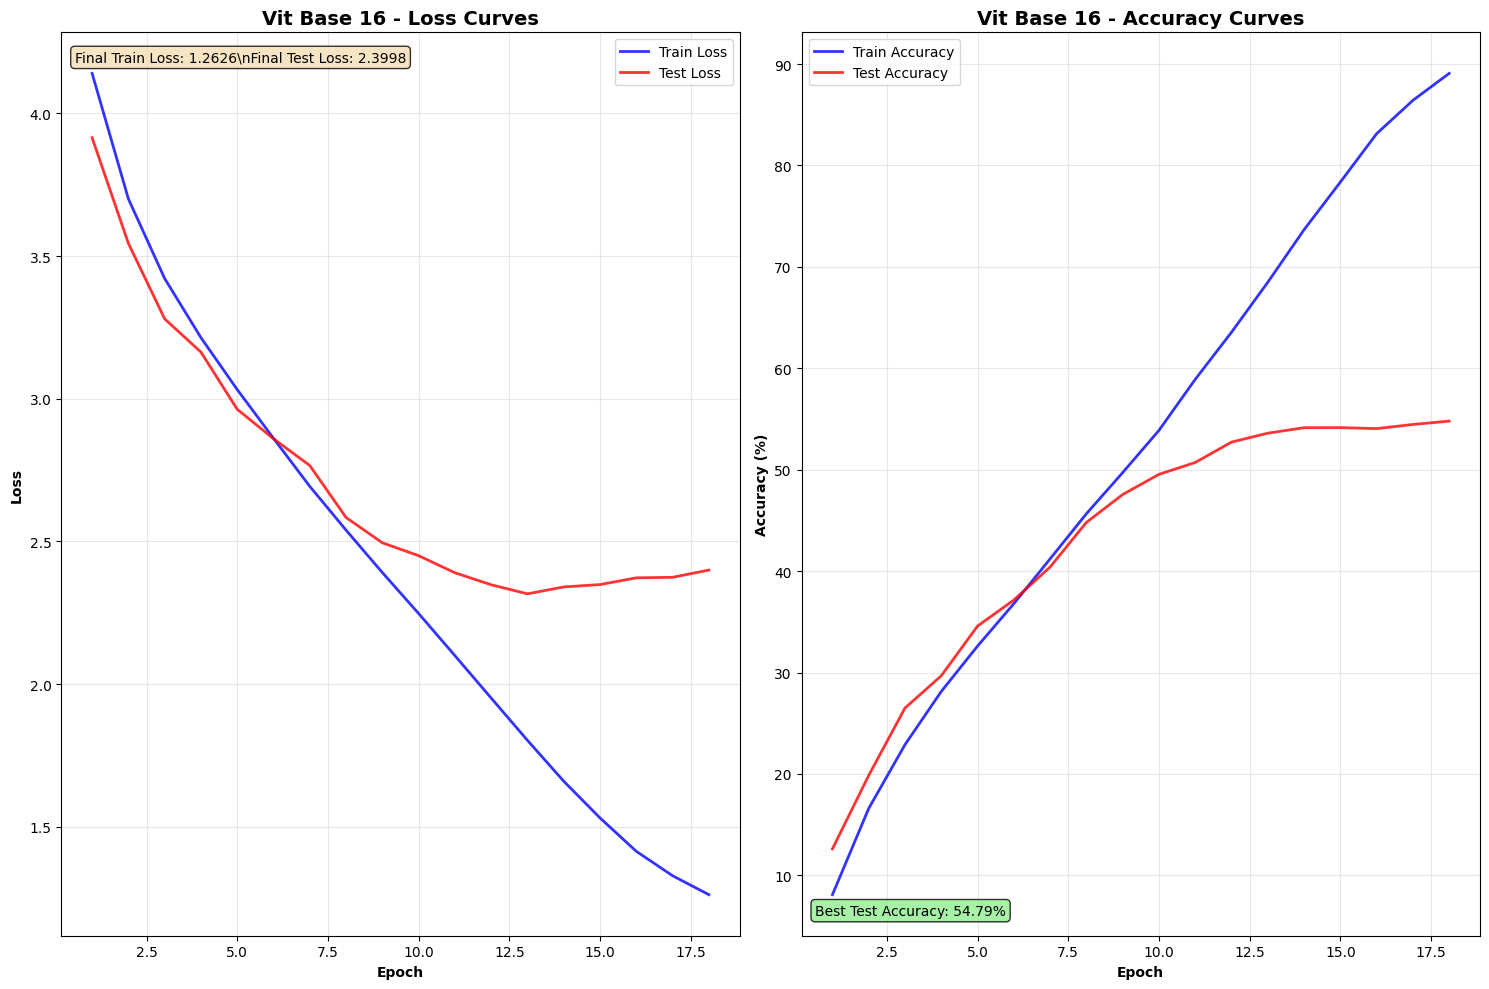

💾 Saved: /content/drive/MyDrive/CIFAR100_Experiment/plots/loss_curves/individual/deit_small_curves.png


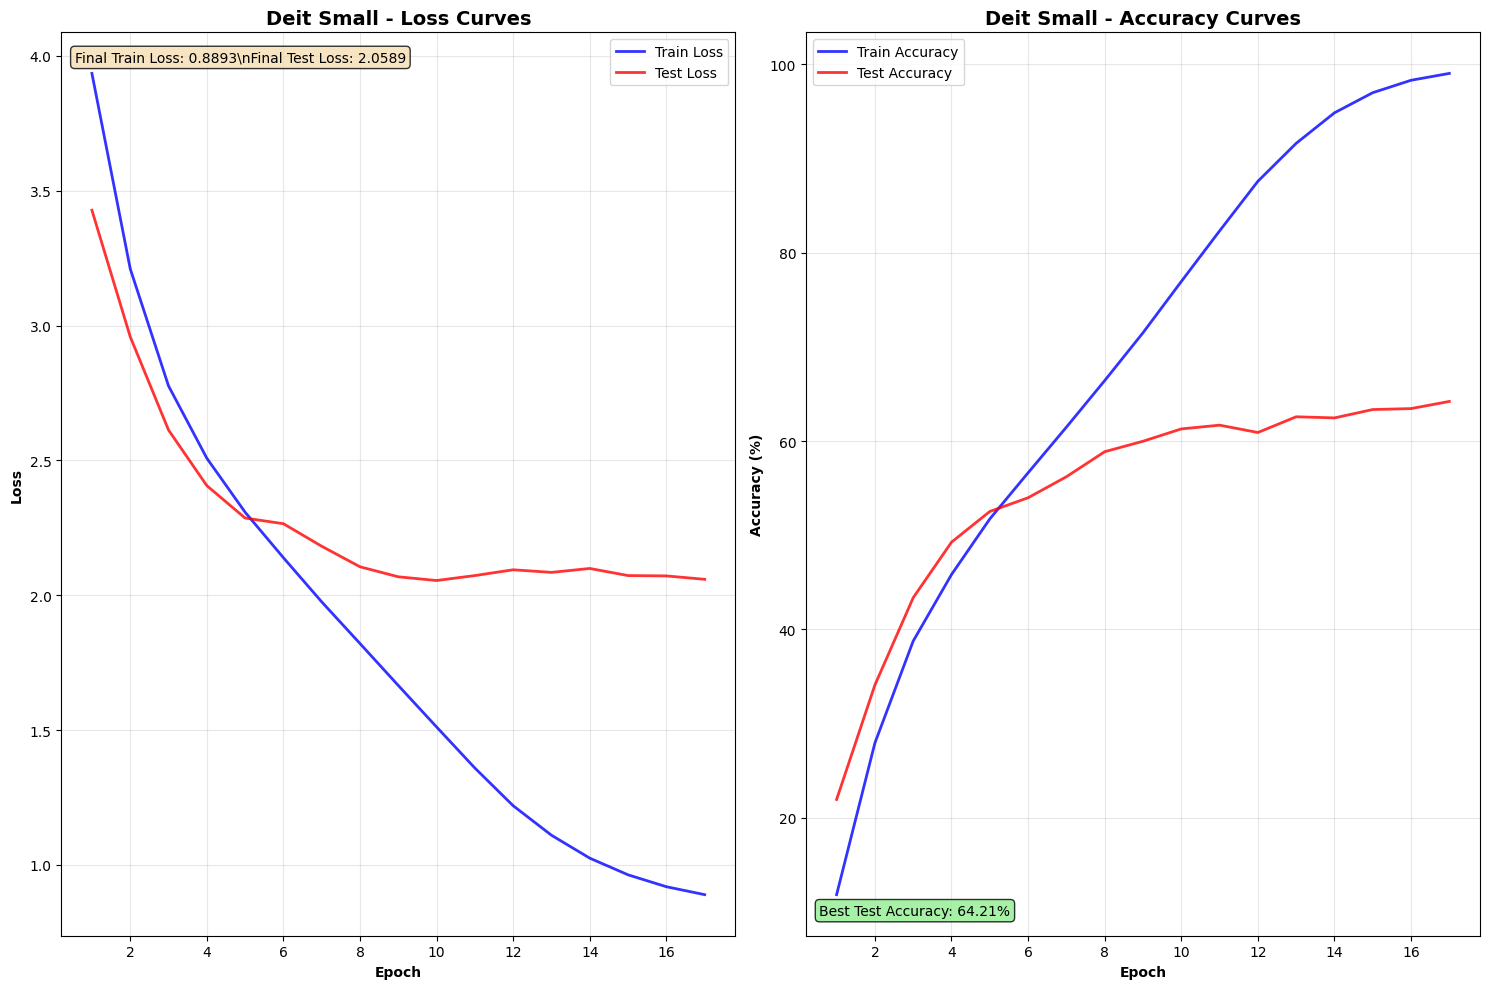

💾 Saved: /content/drive/MyDrive/CIFAR100_Experiment/plots/loss_curves/individual/efficientnet_lite0_curves.png


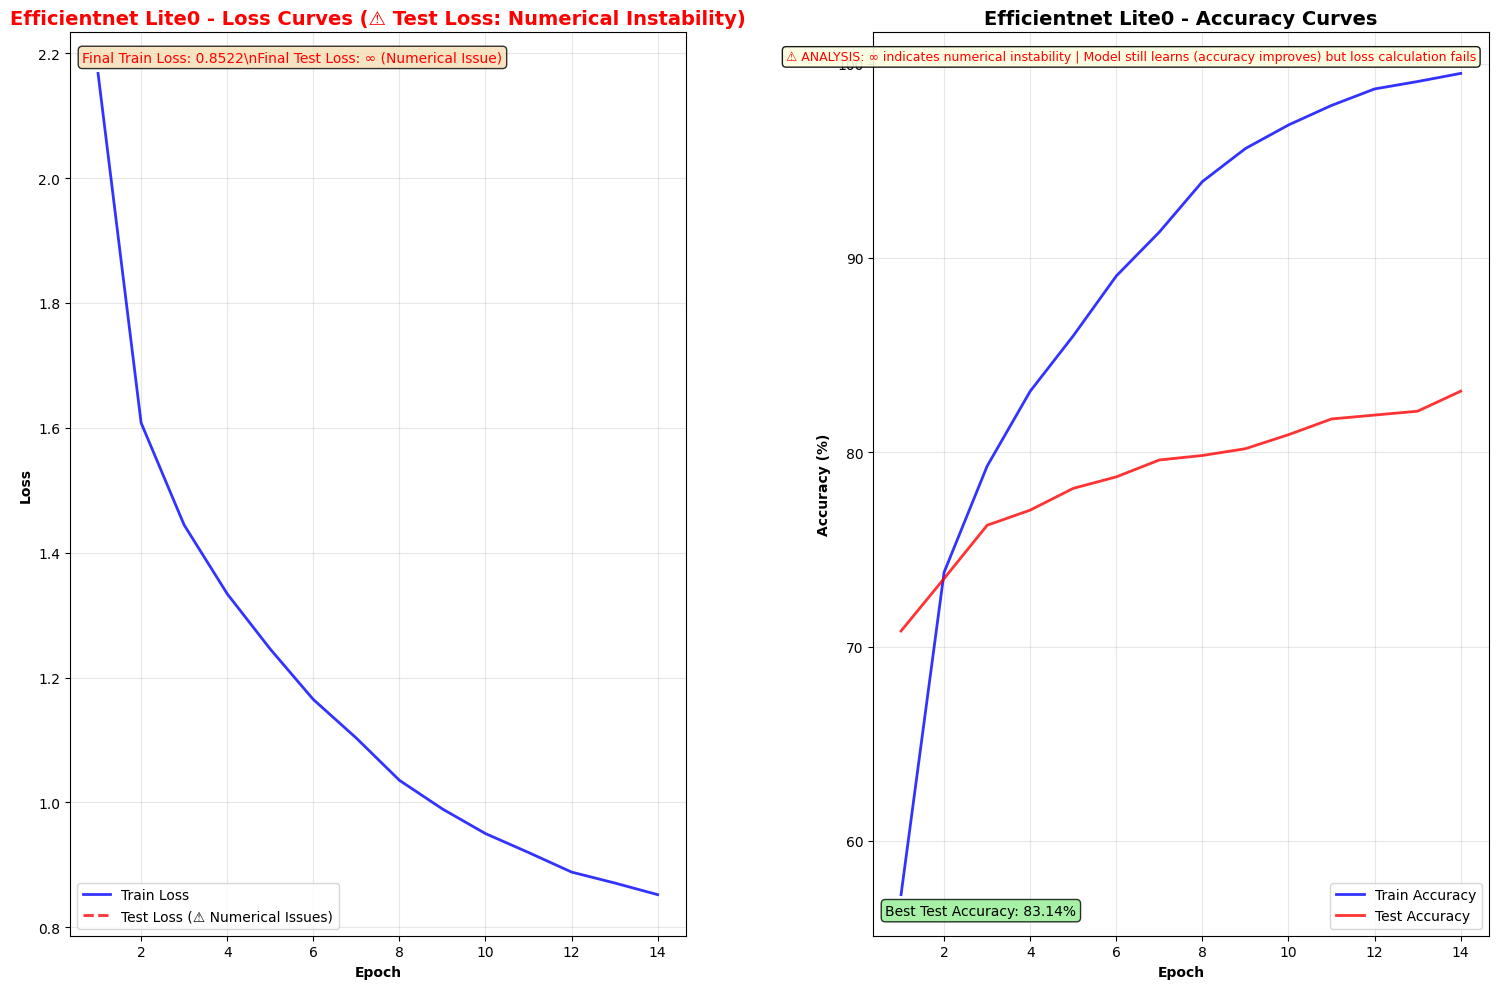

💾 Saved: /content/drive/MyDrive/CIFAR100_Experiment/plots/loss_curves/individual/swin_tiny_curves.png


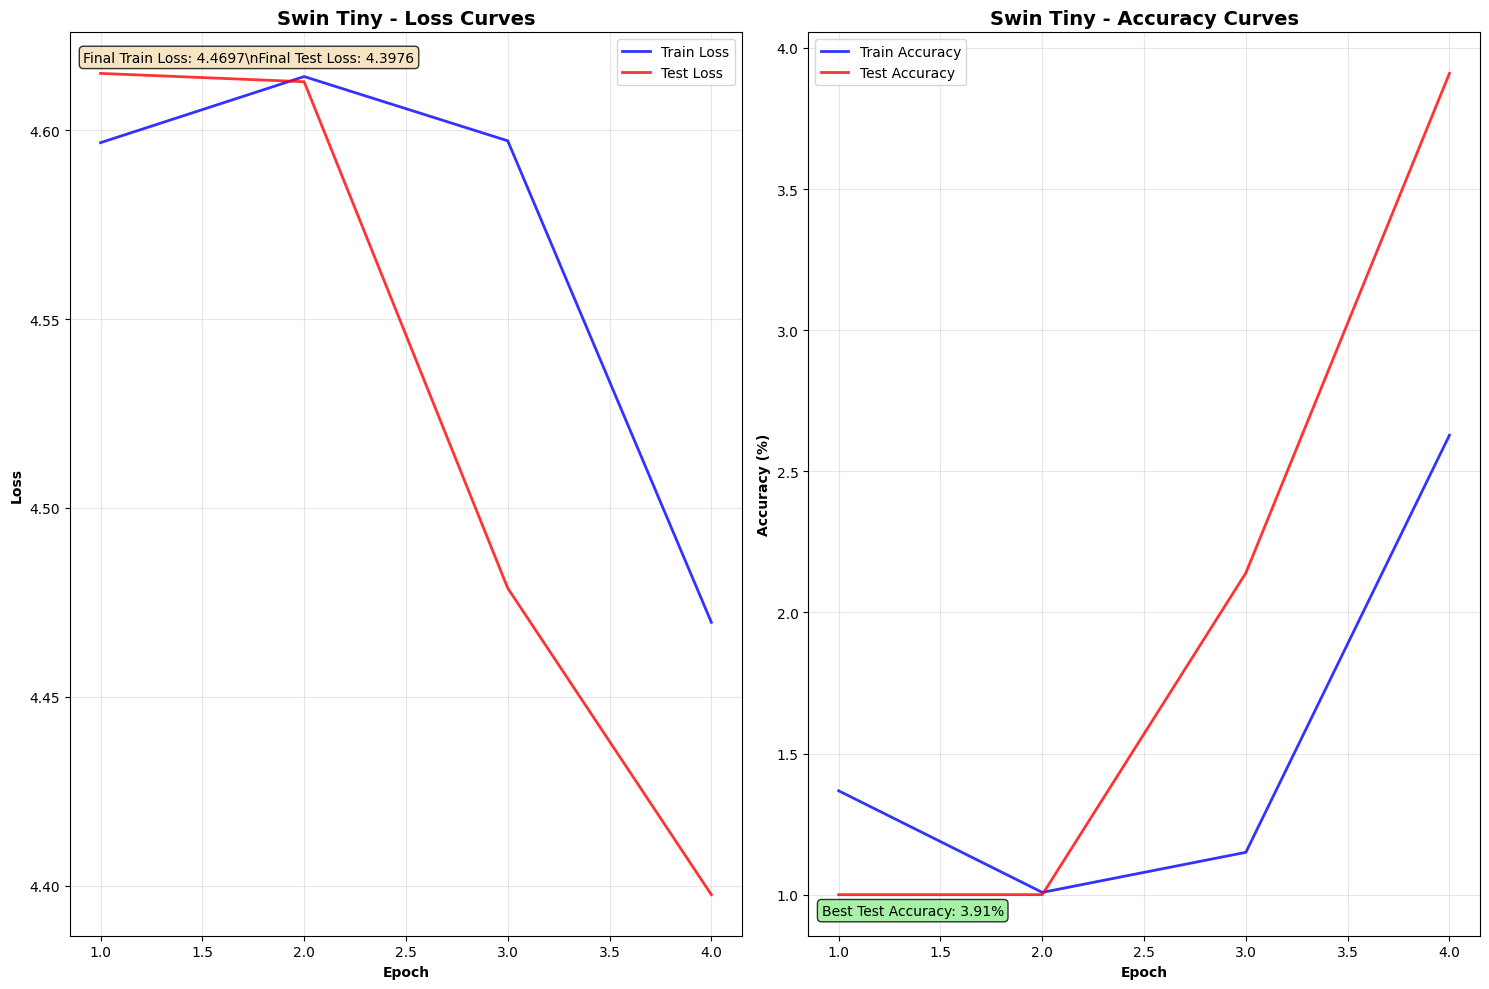

\n🎨 Creating combined loss curves plot...
💾 Saved combined plot: /content/drive/MyDrive/CIFAR100_Experiment/plots/loss_curves/all_models_combined.png


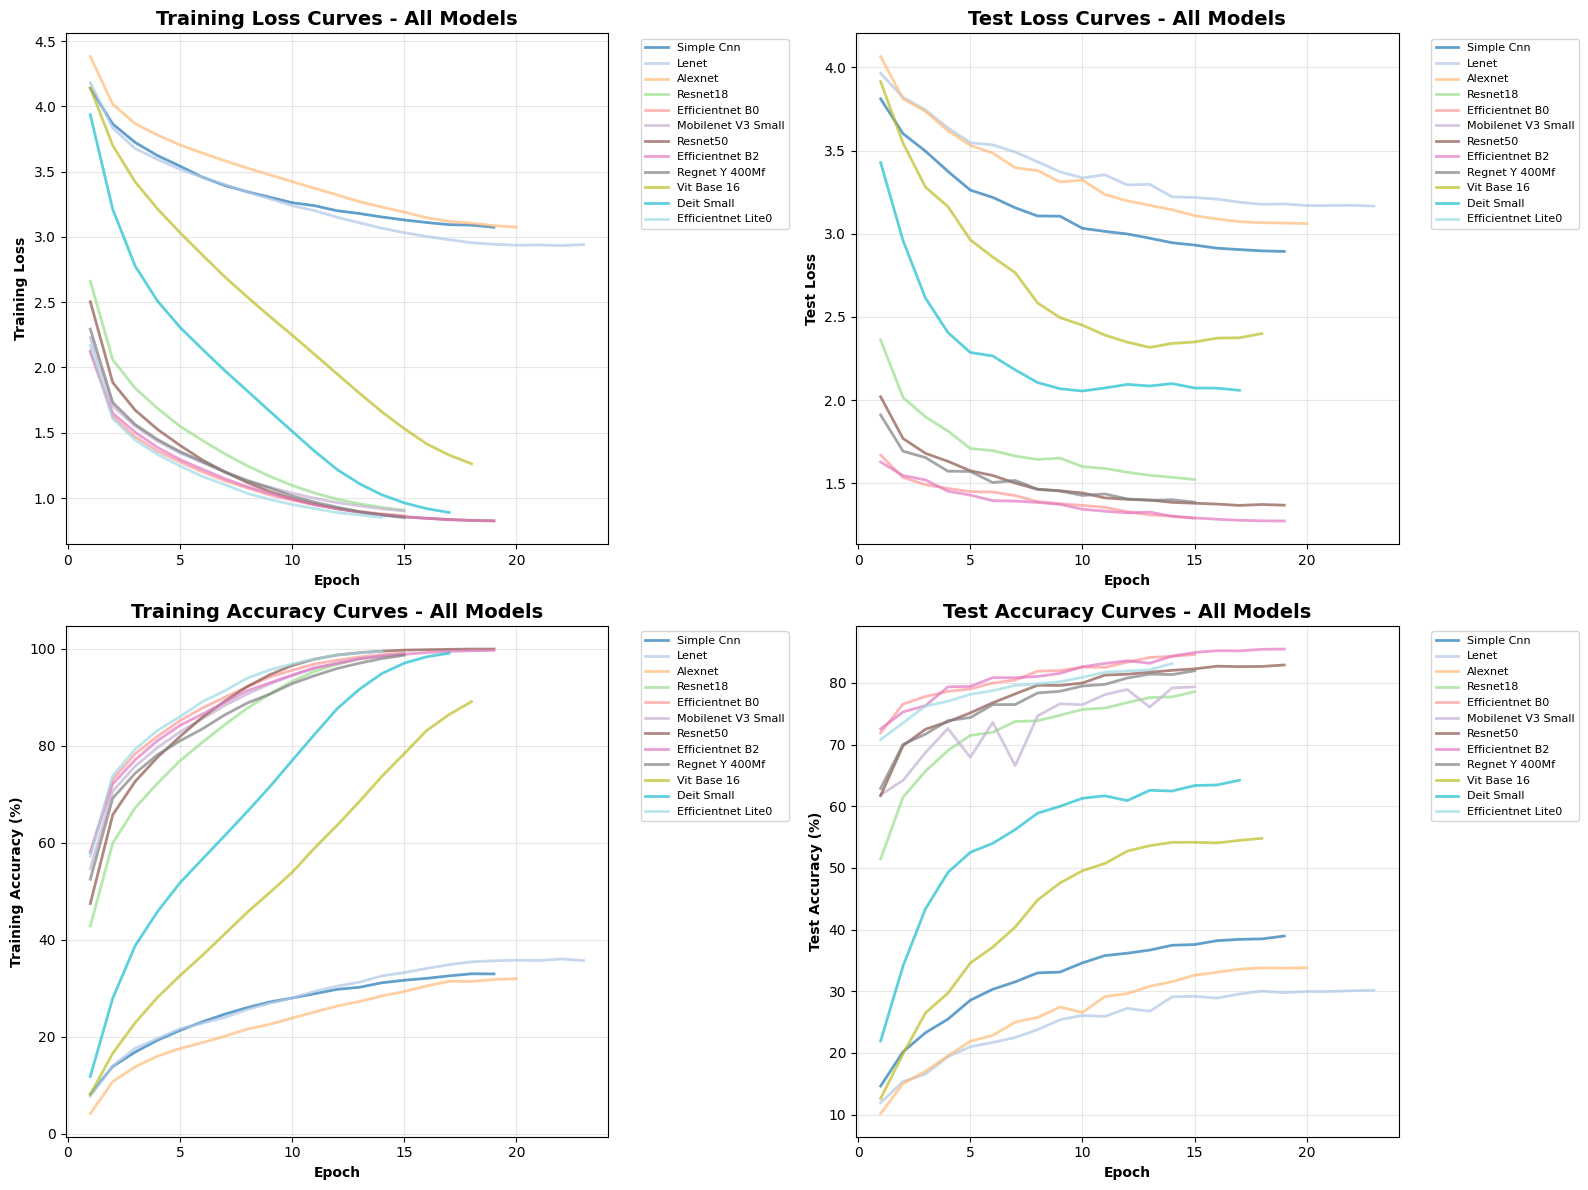

\n🎨 Creating top performers comparison...
💾 Saved top performers plot: /content/drive/MyDrive/CIFAR100_Experiment/plots/loss_curves/top_performers_comparison.png


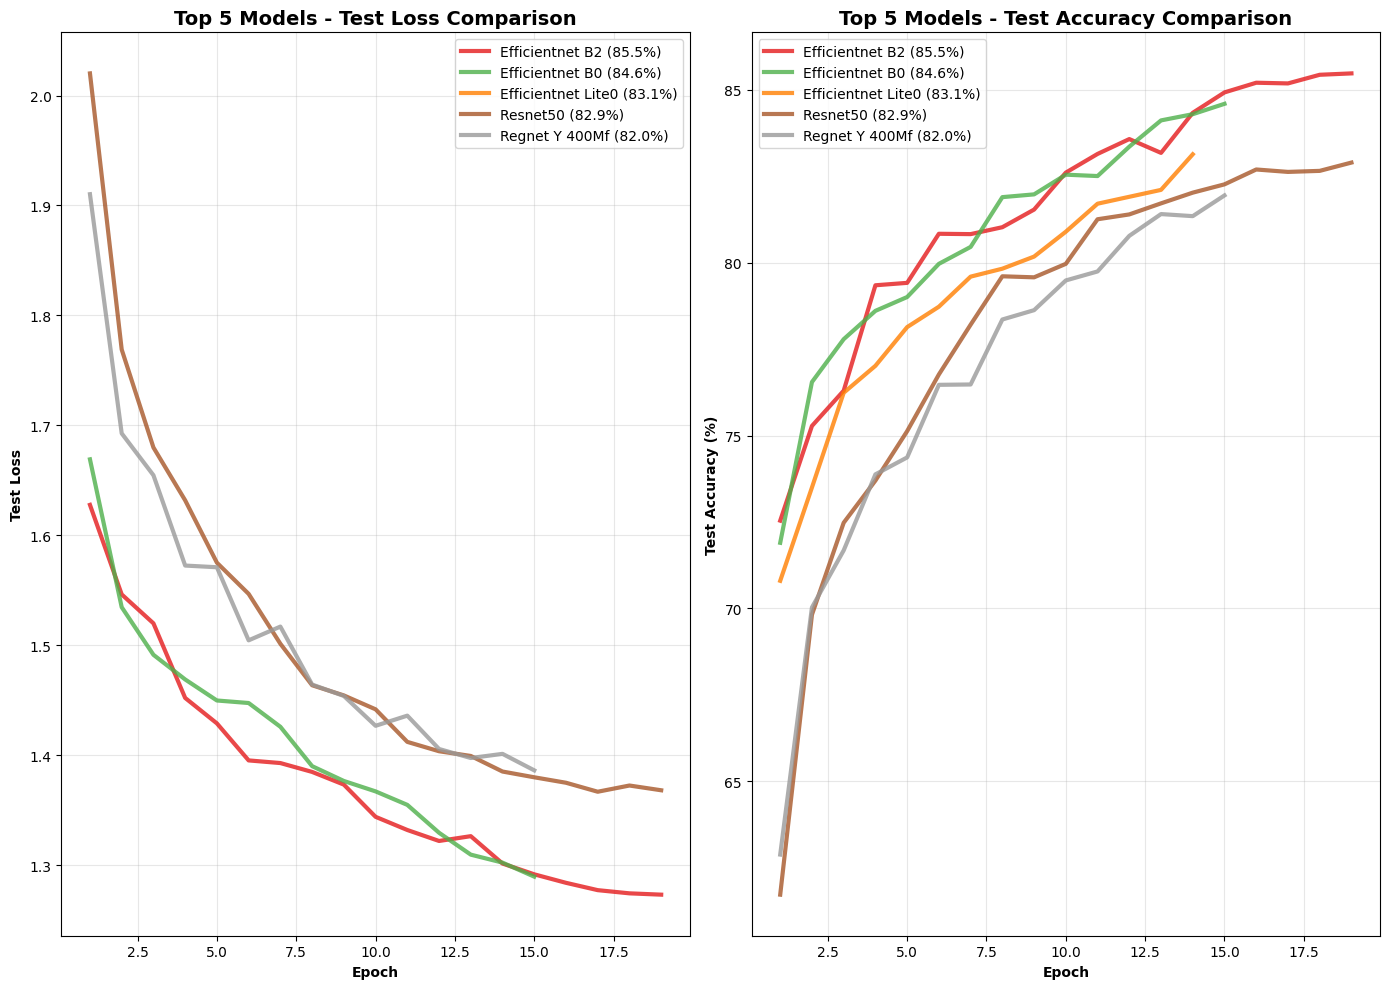

\n✅ All loss curve plots completed!
📂 Plots saved to: /content/drive/MyDrive/CIFAR100_Experiment/plots/loss_curves


In [28]:
curves = create_all_loss_curve_plots()

In [29]:
# Create all loss curve plots
# curves_data = create_all_loss_curve_plots()

# curves_data = extract_all_loss_curves()
# plot_combined_loss_curves(curves_data)
# plot_top_performers_comparison(curves_data, top_n=3)

In [30]:
import json
import pandas as pd

# Path to your JSON file
json_path = "/content/drive/MyDrive/CIFAR100_Experiment/results/FINAL_experiment_results.json"

# Load JSON
with open(json_path, "r") as f:
    data = json.load(f)

# Extract relevant metrics into a list of dictionaries
summary_data = []
for model_id, metrics in data.items():
    summary_data.append({
        "Model": metrics["model_name"],
        "Final Test Accuracy": metrics["final_test_acc"],
        "Training Time (s)": round(metrics["training_time"], 2),
        "Total Parameters": metrics["total_parameters"],
        "Trainable Parameters": metrics["trainable_parameters"]
    })


df = pd.DataFrame(summary_data)

# Sort by accuracy descending
df = df.sort_values(by="Final Test Accuracy", ascending=False).reset_index(drop=True)

df.to_csv('model_summary.csv', index=False)